# Find precipitation value for pulsed and upslope storms

In [1]:
import sys
sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/Thesis/Python')

import numpy as np
import netCDF4
import pandas as pd
import matplotlib.pyplot as plt

import createFolder as cF
np.warnings.filterwarnings('ignore')



In [2]:
m = ['11', '12', '01', '02', '03']
station = 'Haukeliseter'

In [3]:
savefig = 0
if savefig == 1:
    figdir = '../../Figures/Weathermast_MEPS/%s/precip_seasonal_stat' %(station)
    cF.createFolder('%s/' %figdir)
form = 'png'

### Minuelty data

In [4]:
obs_f = dict()
obs_double_fence_acc_mean = dict()
obs_wind_dir_10m   = dict()
obs_wind_speed_10m = dict()
obs_dofe_acc   = dict()
obs_wind_dir   = dict()
obs_wind_speed = dict() 
obs_dofe_acc_rolling = dict()
obs_wind_dir_rolling = dict()
obs_wind_speed_rolling = dict()
obs_diff = dict()
obs_westerly_idx = dict()
obs_easterly_idx = dict()
obs_westerly = dict()
obs_easterly = dict()
obs_total_precip = dict()
obs_precip_west  = dict()
obs_precip_east  = dict()

for month in m:
    if month == '11':
        t = np.arange(7,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day

        obs_dirnc = '../../Data/Weathermast/Met_%s%s%s_%s.nc' %(year,month,day,station)
        obs_f[int(year+month+day)] = netCDF4.Dataset(obs_dirnc, 'r')

        obs_double_fence_acc_mean[int(year+month+day)] = (np.nanmean(obs_f[int(year+month+day)].variables['double_fence_accum'][:], axis=1))
        obs_wind_dir_10m[int(year+month+day)]   = (obs_f[int(year+month+day)].variables['10m_wind_dir_mast1'][:])
        obs_wind_speed_10m[int(year+month+day)] = (obs_f[int(year+month+day)].variables['10m_wind_speed_mast1'][:])
        
        obs_f[int(year+month+day)].close
        
        ## Create a rolling mean to smoothen out the data
        # attach the last 9 minutes from the previous day to calculate the rolling mean every 10 minutes
        if month != '11' and day == '01':
            if month == '12':
                previous_day = '30'
            elif month == '01' or month == '02':
                previous_day = '31'
            elif month == '03':
                previous_day = '28'
            if month == '01':
                previous_month = '12'
                previous_year = str(int(year)-1)
            elif month == '12':
                previous_month = str(int(month)-1)
                previous_year = year
            else:
                previous_month = '0%s' %(int(month)-1)
                previous_year = year
            
        elif int(day)-1 < 10:
            previous_day = '0%s' %(int(day)-1)
            previous_month = month
            previous_year = year
        else:
            previous_day = '%s' %(int(day)-1)
            previous_month = month
            previous_year = year
        if year == '2016' and month == '11' and day == '07':
            continue
        else:
            pp = (np.concatenate((obs_double_fence_acc_mean[int(previous_year+previous_month+previous_day)][-9:],
                                  obs_double_fence_acc_mean[int(year+month+day)][:])))
            obs_dofe_acc[int(year+month+day)] = (pp)
            wd = (np.concatenate((obs_wind_dir_10m[int(previous_year+previous_month+previous_day)][-9:], 
                                  obs_wind_dir_10m[int(year+month+day)][:])))
            obs_wind_dir[int(year+month+day)] = (wd)
            ws = (np.concatenate((obs_wind_speed_10m[int(previous_year+previous_month+previous_day)][-9:], 
                                  obs_wind_speed_10m[int(year+month+day)][:])))
            obs_wind_speed[int(year+month+day)] = (ws)
        # Calculate the moving average. That is, take
        # the first ten values, average them, 
        # then drop the first and add the eleventh, etc.
        obs_dofe_acc[int(year+month+day)] = pd.DataFrame(np.array(obs_dofe_acc[int(year+month+day)])[:])
        obs_dofe_acc_rolling[int(year+month+day)] = obs_dofe_acc[int(year+month+day)].rolling(window=10,
                                                                                              min_periods= 7,
                                                                                              axis=0).mean()
        obs_dofe_acc_rolling[int(year+month+day)] = obs_dofe_acc_rolling[int(year+month+day)].values
        obs_dofe_acc_rolling[int(year+month+day)] = np.array(obs_dofe_acc_rolling[int(year+month+day)])[9:,:]

        obs_wind_dir[int(year+month+day)] = pd.DataFrame(np.array(obs_wind_dir[int(year+month+day)])[:])
        obs_wind_dir_rolling[int(year+month+day)] = obs_wind_dir[int(year+month+day)].rolling(window=10,
                                                                                              min_periods=7,
                                                                                              axis=0).mean()
        obs_wind_dir_rolling[int(year+month+day)] = obs_wind_dir_rolling[int(year+month+day)].values
        obs_wind_dir_rolling[int(year+month+day)] = np.array(obs_wind_dir_rolling[int(year+month+day)])[9:,:]

        obs_wind_speed[int(year+month+day)] = pd.DataFrame(np.array(obs_wind_speed[int(year+month+day)])[:])
        obs_wind_speed_rolling[int(year+month+day)] = obs_wind_speed[int(year+month+day)].rolling(window=10,
                                                                                                  min_periods=7,
                                                                                                  axis=0).mean()
        obs_wind_speed_rolling[int(year+month+day)] = obs_wind_speed_rolling[int(year+month+day)].values
        obs_wind_speed_rolling[int(year+month+day)] = np.array(obs_wind_speed_rolling[int(year+month+day)])[9:,:]
        
        
        ## calculate the precipitation difference, since the minutelty data is accumulated from the beginning
        obs_diff[int(year+month+day)] = np.empty(shape=(obs_dofe_acc_rolling[int(year+month+day)].shape))#/60))
        obs_diff[int(year+month+day)][:] =  np.nan

        for i in np.arange(0,obs_dofe_acc_rolling[int(year+month+day)].shape[0]-1):#/60):
            obs_diff[int(year+month+day)][int(i),:] = obs_dofe_acc_rolling[int(year+month+day)][int(i)+1] - \
                                                      obs_dofe_acc_rolling[int(year+month+day)][int(i)]


        # Find wind regimes and associated precip amount
        IDX = np.arange(obs_wind_dir_rolling[int(year+month+day)].shape[0])

        ## find all obs_westerly regimes (202.5 - 22.5 deg) 
        obs_westerly_idx[int(year+month+day)]  = IDX[np.logical_or(np.logical_and((obs_wind_dir_rolling[int(year+month+day)][:,0] >= 202.5), 
                                                                              (obs_wind_dir_rolling[int(year+month+day)][:,0] <= 360)),
                                                              (obs_wind_dir_rolling[int(year+month+day)][:,0] <22.5))]
        ## find all obs_easterly regimes (22.5 - 202.5 deg)
        obs_easterly_idx[int(year+month+day)]  = IDX[np.logical_and((obs_wind_dir_rolling[int(year+month+day)][:,0] >= 22.5),
                                                                (obs_wind_dir_rolling[int(year+month+day)][:,0] < 202.5))]

        ## find indices for all obs_westerly regimes 
        sub_idx = []

        for i in range(0,obs_westerly_idx[int(year+month+day)] .shape[0]-1):
            if obs_westerly_idx[int(year+month+day)] [i]+1 == obs_westerly_idx[int(year+month+day)] [i+1]:
                continue
            else:
                #print(i)
                sub_idx.append(i)
    
    #        print([int(year+month+day)], obs_westerly_idx[int(year+month+day)], sub_idx)
        
        
        ## find westerlies which are < 29 min and assign them to obs_easterly wind regime
        if len(obs_westerly_idx[int(year+month+day)]) == 0 and len(sub_idx) == 0:     # westerlies do not exist
            obs_westerly[int(year+month+day)] = []
            obs_easterly[int(year+month+day)] = obs_easterly_idx[int(year+month+day)]
#            print('No obs_westerly wind on %s' %(int(year+month+day)))
        elif len(obs_westerly_idx[int(year+month+day)]) != 0 and len(sub_idx) == 0:   # westerlies exist only for one time period a day
            obs_westerly[int(year+month+day)] = []
      #      obs_easterly[int(year+month+day)] = []
            obs_easterly[int(year+month+day)] = obs_easterly_idx[int(year+month+day)]
            
            obs_westerly_duration = obs_westerly_idx[int(year+month+day)][-1] - obs_westerly_idx[int(year+month+day)][0]
            if obs_westerly_duration >= 28:
                obs_westerly[int(year+month+day)] = np.concatenate((obs_westerly[int(year+month+day)],
                                                                obs_westerly_idx[int(year+month+day)][:]))
            elif obs_westerly_duration < 28:
                obs_easterly[int(year+month+day)] = np.concatenate((obs_easterly[int(year+month+day)],
                                                                obs_westerly_idx[int(year+month+day)][:]))
        else:
            obs_westerly[int(year+month+day)] = []
         #   obs_easterly[int(year+month+day)] = []
            obs_easterly[int(year+month+day)] = obs_easterly_idx[int(year+month+day)]

            for i in np.arange(0,np.array(sub_idx).shape[0]+1):                # westerlies and easterlies interchange daily
                if i == 0:
                    obs_westerly_duration = (obs_westerly_idx[int(year+month+day)] [ sub_idx[0]] - \
                                         obs_westerly_idx[int(year+month+day)] [0])
                elif i == np.array(sub_idx).shape[0]:
                    obs_westerly_duration = (obs_westerly_idx[int(year+month+day)] [-1] - \
                                         obs_westerly_idx[int(year+month+day)] [ sub_idx[np.array(sub_idx).shape[0]-1]+1])
                else:
                    obs_westerly_duration = (obs_westerly_idx[int(year+month+day)] [ sub_idx[i]] - \
                                         obs_westerly_idx[int(year+month+day)] [ sub_idx[i-1]+1])
                if obs_westerly_duration >= 28:
                    if i == 0:
                        obs_westerly[int(year+month+day)] = np.concatenate((obs_westerly[int(year+month+day)], 
                                                                        obs_westerly_idx[int(year+month+day)] [ 0: sub_idx[0]+1]))
            #            print(obs_westerly_duration, RR_obs_westerly)
                    elif i == np.array(sub_idx).shape[0]:
                        obs_westerly[int(year+month+day)] = np.concatenate((obs_westerly[int(year+month+day)], 
                                                                        obs_westerly_idx[int(year+month+day)] [ sub_idx[np.array(sub_idx).shape[0]-1]+1 : ]))
             #           print(obs_westerly_duration, RR_obs_westerly)
                    else:
                        obs_westerly[int(year+month+day)] = np.concatenate((obs_westerly[int(year+month+day)], 
                                                                        obs_westerly_idx[int(year+month+day)] [ sub_idx[i-1]+1 : sub_idx[i]+1]))
              #          print(obs_westerly_duration, RR_obs_westerly)
                elif obs_westerly_duration < 28:
                    if i == 0:
                        obs_easterly[int(year+month+day)] = np.concatenate((obs_easterly[int(year+month+day)], 
                                                                        obs_westerly_idx[int(year+month+day)] [ 0: sub_idx[0]+1]))
                    elif i == np.array(sub_idx).shape[0]:
                        obs_easterly[int(year+month+day)] = np.concatenate((obs_easterly[int(year+month+day)],
                                                                        obs_westerly_idx[int(year+month+day)] [ sub_idx[np.array(sub_idx).shape[0]-1]+1 : ]))
                    else:
                   # print(obs_westerly_duration)
                        obs_easterly[int(year+month+day)] = np.concatenate((obs_easterly[int(year+month+day)],
                                                                        obs_westerly_idx[int(year+month+day)] [ sub_idx[i-1]+1 : sub_idx[i]+1]))
        

        if len(obs_westerly[int(year+month+day)]) == 0:    # only easterlies
            obs_easterly[int(year+month+day)]  = obs_easterly[int(year+month+day)].astype(int)

#            print([int(year+month+day)], 
 #                 'total precipitation [mm/24h]:', 
  #                np.round(np.nansum(obs_diff[int(year+month+day)][obs_easterly_idx[int(year+month+day)],:]) + \
   #                        np.nansum(obs_diff[int(year+month+day)][obs_westerly_idx[int(year+month+day)],:]),2 ),
    #              'obs_easterly [mm/24h]:', 
     #             np.round(np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)],:]),2),
      #            'obs_westerly [mm/24h]:', 
       #           np.round(len(obs_westerly[int(year+month+day)]),2))
        elif len(obs_easterly[int(year+month+day)]) == 0:  # only westerlies
            obs_westerly[int(year+month+day)]  = obs_westerly[int(year+month+day)].astype(int)

#            print([int(year+month+day)], 
 #                 'total precipitation [mm/24h]:', 
  #                np.round(np.nansum(obs_diff[int(year+month+day)][obs_easterly_idx[int(year+month+day)],:]) + \
   #                        np.nansum(obs_diff[int(year+month+day)][obs_westerly_idx[int(year+month+day)],:]),2 ),
    #              'obs_easterly [mm/24h]:', 
     #             np.round(len(obs_easterly[int(year+month+day)]),2),
      #            'obs_westerly [mm/24h]:', 
       #           np.round(np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)],:]),2))
        else:    # both easterlies and westerlies
            obs_easterly[int(year+month+day)]  = obs_easterly[int(year+month+day)].astype(int)
            obs_westerly[int(year+month+day)]  = obs_westerly[int(year+month+day)].astype(int)
            
#            print([int(year+month+day)], 
 #                 'total precipitation [mm/24h]:', 
  #                np.round(np.nansum(obs_diff[int(year+month+day)][obs_easterly_idx[int(year+month+day)],:]) + \
   #                        np.nansum(obs_diff[int(year+month+day)][obs_westerly_idx[int(year+month+day)],:]),2 ),
    #              'obs_easterly [mm/24h]:', 
     #             np.round(np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)],:]),2),
      #            'obs_westerly [mm/24h]:', 
       #           np.round(np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)],:]),2))
            
        # assign sum values to days
        if len(obs_easterly[int(year+month+day)]) == 0 and len(obs_westerly[int(year+month+day)]) == 0:
            obs_total_precip[int(year+month+day)] = np.nan
            obs_precip_east[int(year+month+day)] =  np.nan
            obs_precip_west[int(year+month+day)] =  np.nan
        else:
            obs_total_precip[int(year+month+day)] = np.nansum(obs_diff[int(year+month+day)][obs_easterly_idx[int(year+month+day)],:]) + \
                                                np.nansum(obs_diff[int(year+month+day)][obs_westerly_idx[int(year+month+day)],:])
            obs_precip_east[int(year+month+day)] = np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)],:])
            obs_precip_west[int(year+month+day)] = np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)],:])
            
        print([int(year+month+day)], 'total:', np.round(obs_total_precip[int(year+month+day)],2),
                                        'westerly:',  np.round(obs_precip_west[int(year+month+day)],2),
                                         'easterly:', np.round(obs_precip_east[int(year+month+day)],2) )

[20161108] total: -0.01 westerly: 0.0 easterly: -0.01
[20161109] total: 0.31 westerly: 0.0 easterly: 0.31
[20161110] total: 0.12 westerly: 0.09 easterly: 0.03
[20161111] total: -0.03 westerly: -0.17 easterly: 0.14
[20161112] total: 3.45 westerly: 0.0 easterly: 3.45
[20161113] total: 1.47 westerly: 0.36 easterly: 1.11
[20161114] total: 3.43 westerly: 1.21 easterly: 2.22
[20161115] total: 4.44 westerly: 2.06 easterly: 2.38
[20161116] total: 14.58 westerly: 8.67 easterly: 5.91
[20161117] total: 9.0 westerly: 7.42 easterly: 1.58
[20161118] total: 4.83 westerly: 1.61 easterly: 3.22
[20161119] total: nan westerly: nan easterly: nan
[20161120] total: nan westerly: nan easterly: nan
[20161121] total: nan westerly: nan easterly: nan
[20161122] total: -0.19 westerly: 0.0 easterly: -0.19
[20161123] total: 3.4 westerly: 0.27 easterly: 3.13
[20161124] total: 1.33 westerly: 1.17 easterly: 0.16
[20161125] total: -0.04 westerly: -0.04 easterly: 0.0
[20161126] total: 0.34 westerly: 0.34 easterly: 0.0
[

### Eklima data

In [5]:
eklima_f = dict()
eklima_double_fence_acc = dict()
eklima_wind_dir_10m   = dict()
eklima_wind_speed_10m = dict()
eklima_diff = dict()
eklima_westerly_idx = dict()
eklima_easterly_idx = dict()
eklima_westerly = dict()
eklima_easterly = dict()
eklima_total_precip = dict()
eklima_precip_west  = dict()
eklima_precip_east  = dict()

for month in m:
    if month == '11':
        t = np.arange(8,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day

        eklima_dirnc = '../../Data/Eklima/%s/precip_wind_temp_%s%s%s.nc' %(station,year,month,day)
        eklima_f[int(year+month+day)] = netCDF4.Dataset(eklima_dirnc, 'r')

        eklima_double_fence_acc[int(year+month+day)] = (eklima_f[int(year+month+day)].variables['RR_1'][:])
        eklima_wind_dir_10m[int(year+month+day)]   = (eklima_f[int(year+month+day)].variables['DD'][:])
        eklima_wind_speed_10m[int(year+month+day)] = (eklima_f[int(year+month+day)].variables['FF'][:])
        
        eklima_f[int(year+month+day)].close
        

        ## calculate the precipitation difference, since the minutelty data is accumulated from the beginning
        eklima_diff[int(year+month+day)] = np.empty(shape=(eklima_double_fence_acc[int(year+month+day)].shape))#/60))
        eklima_diff[int(year+month+day)][:] =  np.nan

        eklima_diff[int(year+month+day)][:,] = eklima_double_fence_acc[int(year+month+day)]

        # Find wind regimes and associated precip amount
        IDX = np.arange(eklima_wind_dir_10m[int(year+month+day)].shape[0])

        ## find all eklima_westerly regimes (202.5 - 22.5 deg) 
        eklima_westerly_idx[int(year+month+day)]  = IDX[np.logical_or(np.logical_and((eklima_wind_dir_10m[int(year+month+day)][:,] >= 202.5),
                                                                                     (eklima_wind_dir_10m[int(year+month+day)][:,] <= 360)),
                                                                      (eklima_wind_dir_10m[int(year+month+day)][:,] <22.5))]

        ## find all eklima_easterly regimes (22.5 - 202.5 deg)
        eklima_easterly_idx[int(year+month+day)]  = IDX[np.logical_and((eklima_wind_dir_10m[int(year+month+day)][:,] >= 22.5),
                                                                       (eklima_wind_dir_10m[int(year+month+day)][:,] < 202.5))]

        eklima_westerly[int(year+month+day)] = eklima_westerly_idx[int(year+month+day)]
        eklima_easterly[int(year+month+day)] = eklima_easterly_idx[int(year+month+day)]

        if len(eklima_westerly[int(year+month+day)]) == 0:    # only easterlies
            eklima_easterly[int(year+month+day)]  = eklima_easterly[int(year+month+day)].astype(int)

#            print([int(year+month+day)], 
 #                 'total precipitation [mm/24h]:', 
  #                np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_easterly_idx[int(year+month+day)],]) + \
   #                        np.nansum(eklima_diff[int(year+month+day)][eklima_westerly_idx[int(year+month+day)],]),2 ),
    #              'eklima_easterly [mm/24h]:', 
     #             np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_easterly[int(year+month+day)],]),2),
      #            'eklima_westerly [mm/24h]:', 
       #           np.round(len(eklima_westerly[int(year+month+day)]),2))

        elif len(eklima_easterly[int(year+month+day)]) == 0:  # only westerlies
            eklima_westerly[int(year+month+day)]  = eklima_westerly[int(year+month+day)].astype(int)

#            print([int(year+month+day)], 
 #                 'total precipitation [mm/24h]:', 
  #                np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_easterly_idx[int(year+month+day)],]) + \
   #                        np.nansum(eklima_diff[int(year+month+day)][eklima_westerly_idx[int(year+month+day)],]),2 ),
    #              'eklima_easterly [mm/24h]:', 
     #             np.round(len(eklima_easterly[int(year+month+day)]),2),
      #            'eklima_westerly [mm/24h]:', 
       #           np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_westerly[int(year+month+day)],]),2))
        else:    # both easterlies and westerlies
            eklima_easterly[int(year+month+day)]  = eklima_easterly[int(year+month+day)].astype(int)
            eklima_westerly[int(year+month+day)]  = eklima_westerly[int(year+month+day)].astype(int)
            
#            print([int(year+month+day)], 
 #                 'total precipitation [mm/24h]:', 
  #                np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_easterly_idx[int(year+month+day)],]) + \
   #                        np.nansum(eklima_diff[int(year+month+day)][eklima_westerly_idx[int(year+month+day)],]),2 ),
    #              'eklima_easterly [mm/24h]:', 
     #             np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_easterly[int(year+month+day)],]),2),
      #            'eklima_westerly [mm/24h]:', 
       #           np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_westerly[int(year+month+day)],]),2))

        # assign sum values to days
        if len(eklima_easterly[int(year+month+day)]) == 0 and len(eklima_westerly[int(year+month+day)]) == 0:
            eklima_total_precip[int(year+month+day)] = np.nan
            eklima_precip_east[int(year+month+day)] = np.nan
            eklima_precip_west[int(year+month+day)] = np.nan
        else:
            eklima_total_precip[int(year+month+day)] = np.nansum(eklima_diff[int(year+month+day)][eklima_easterly_idx[int(year+month+day)],]) + \
                                           np.nansum(eklima_diff[int(year+month+day)][eklima_westerly_idx[int(year+month+day)],])
            eklima_precip_east[int(year+month+day)] = np.nansum(eklima_diff[int(year+month+day)][eklima_easterly[int(year+month+day)],])
            eklima_precip_west[int(year+month+day)] = np.nansum(eklima_diff[int(year+month+day)][eklima_westerly[int(year+month+day)],])
        
#        print([int(year+month+day)], 'observ total:', np.round(obs_total_precip[int(year+month+day)],2),
 #                                       'westerly:',  np.round(obs_precip_west[int(year+month+day)],2),
  #                                       'easterly:', np.round(obs_precip_east[int(year+month+day)],2) )
#        print([int(year+month+day)], 'eklima total:', np.round(eklima_total_precip[int(year+month+day)],2),
 #                                       'westerly:',  np.round(eklima_precip_west[int(year+month+day)],2),
  #                                       'easterly:', np.round(eklima_precip_east[int(year+month+day)],2) )

 

        if obs_total_precip[int(year+month+day)] < 0:
            if obs_precip_east[int(year+month+day)] < 0 and obs_precip_west[int(year+month+day)] < 0:
#                print([int(year+month+day)], 'all are negative',obs_total_precip[int(year+month+day)],obs_precip_east[int(year+month+day)],obs_precip_west[int(year+month+day)])
                obs_total_precip[int(year+month+day)] = eklima_total_precip[int(year+month+day)]
                obs_precip_east[int(year+month+day)] = eklima_precip_east[int(year+month+day)]
                obs_precip_west[int(year+month+day)] = eklima_precip_west[int(year+month+day)]
                obs_wind_speed_rolling[int(year+month+day)] = eklima_wind_speed_10m[int(year+month+day)]
                obs_wind_dir_rolling[int(year+month+day)] = eklima_wind_dir_10m[int(year+month+day)]
#                print([int(year+month+day)], 'all are negative',obs_total_precip[int(year+month+day)],obs_precip_east[int(year+month+day)],obs_precip_west[int(year+month+day)])
    
            elif obs_precip_east[int(year+month+day)] < 0:
#                print([int(year+month+day)], 'total and east',obs_total_precip[int(year+month+day)],obs_precip_east[int(year+month+day)])
                obs_total_precip[int(year+month+day)] = eklima_total_precip[int(year+month+day)]
                obs_precip_east[int(year+month+day)] = eklima_precip_east[int(year+month+day)]
                obs_precip_west[int(year+month+day)] = eklima_precip_west[int(year+month+day)]
                obs_wind_speed_rolling[int(year+month+day)] = eklima_wind_speed_10m[int(year+month+day)]
                obs_wind_dir_rolling[int(year+month+day)] = eklima_wind_dir_10m[int(year+month+day)]
#                print([int(year+month+day)], 'total and east',obs_total_precip[int(year+month+day)],obs_precip_east[int(year+month+day)])
        
            elif obs_precip_west[int(year+month+day)] < 0:
#                print([int(year+month+day)], 'total and west',obs_total_precip[int(year+month+day)],obs_precip_west[int(year+month+day)])
                obs_total_precip[int(year+month+day)] = eklima_total_precip[int(year+month+day)]
                obs_precip_east[int(year+month+day)] = eklima_precip_east[int(year+month+day)]
                obs_precip_west[int(year+month+day)] = eklima_precip_west[int(year+month+day)]
                obs_wind_speed_rolling[int(year+month+day)] = eklima_wind_speed_10m[int(year+month+day)]
                obs_wind_dir_rolling[int(year+month+day)] = eklima_wind_dir_10m[int(year+month+day)]
#                print([int(year+month+day)], 'total and west',obs_total_precip[int(year+month+day)],obs_precip_west[int(year+month+day)])
        
        elif obs_precip_east[int(year+month+day)] < 0:
#            print([int(year+month+day)], 'only east',obs_precip_east[int(year+month+day)])
            obs_total_precip[int(year+month+day)] = eklima_total_precip[int(year+month+day)]
            obs_precip_east[int(year+month+day)] = eklima_precip_east[int(year+month+day)]
            obs_precip_west[int(year+month+day)] = eklima_precip_west[int(year+month+day)]
            obs_wind_speed_rolling[int(year+month+day)] = eklima_wind_speed_10m[int(year+month+day)]
            obs_wind_dir_rolling[int(year+month+day)] = eklima_wind_dir_10m[int(year+month+day)]
#            print([int(year+month+day)], 'only east',obs_precip_east[int(year+month+day)])   
    
        elif obs_precip_west[int(year+month+day)] < 0:
#            print([int(year+month+day)], 'only west',obs_precip_west[int(year+month+day)])
            obs_total_precip[int(year+month+day)] = eklima_total_precip[int(year+month+day)]
            obs_precip_east[int(year+month+day)] = eklima_precip_east[int(year+month+day)]
            obs_precip_west[int(year+month+day)] = eklima_precip_west[int(year+month+day)]
            obs_wind_speed_rolling[int(year+month+day)] = eklima_wind_speed_10m[int(year+month+day)]
            obs_wind_dir_rolling[int(year+month+day)] = eklima_wind_dir_10m[int(year+month+day)]
#            print([int(year+month+day)], 'only west',obs_precip_west[int(year+month+day)])
        elif np.isnan(obs_total_precip[int(year+month+day)]):
            obs_total_precip[int(year+month+day)] = eklima_total_precip[int(year+month+day)]
            obs_precip_east[int(year+month+day)] = eklima_precip_east[int(year+month+day)]
            obs_precip_west[int(year+month+day)] = eklima_precip_west[int(year+month+day)]
            obs_wind_speed_rolling[int(year+month+day)] = eklima_wind_speed_10m[int(year+month+day)]
            obs_wind_dir_rolling[int(year+month+day)] = eklima_wind_dir_10m[int(year+month+day)]
        
        print([int(year+month+day)], 'observ total:', np.round(obs_total_precip[int(year+month+day)],2),
                                        'westerly:',  np.round(obs_precip_west[int(year+month+day)],2),
                                         'easterly:', np.round(obs_precip_east[int(year+month+day)],2) )


[20161108] observ total: nan westerly: nan easterly: nan
[20161109] observ total: 0.31 westerly: 0.0 easterly: 0.31
[20161110] observ total: 0.12 westerly: 0.09 easterly: 0.03
[20161111] observ total: nan westerly: nan easterly: nan
[20161112] observ total: 3.45 westerly: 0.0 easterly: 3.45
[20161113] observ total: 1.47 westerly: 0.36 easterly: 1.11
[20161114] observ total: 3.43 westerly: 1.21 easterly: 2.22
[20161115] observ total: 4.44 westerly: 2.06 easterly: 2.38
[20161116] observ total: 14.58 westerly: 8.67 easterly: 5.91
[20161117] observ total: 9.0 westerly: 7.42 easterly: 1.58
[20161118] observ total: 4.83 westerly: 1.61 easterly: 3.22
[20161119] observ total: nan westerly: nan easterly: nan
[20161120] observ total: nan westerly: nan easterly: nan
[20161121] observ total: nan westerly: nan easterly: nan
[20161122] observ total: nan westerly: nan easterly: nan
[20161123] observ total: 3.4 westerly: 0.27 easterly: 3.13
[20161124] observ total: 1.33 westerly: 1.17 easterly: 0.16
[

### MEPS data

In [6]:
def fill_values(variable):
    if np.ma.is_masked(variable):
        mask = np.ma.getmaskarray(variable[:,:,:])
        marr = np.ma.array(variable[:,:,:], mask = mask, fill_value = np.nan)
        filled = marr.filled(np.nan)
        
    else:
        filled = variable[:]
        
    return(filled)

In [7]:
meps_f = dict()
meps_precip_acc = dict()
meps_xwind_10m = dict()
meps_ywind_10m = dict()
meps_diff = dict()
meps_wind_dir   = dict()
meps_wind_speed = dict()
meps_westerly_idx = dict()
meps_easterly_idx = dict()
meps_westerly = dict()
meps_easterly = dict()
meps_total_precip = dict()
meps_precip_west  = dict()
meps_precip_east  = dict()

for month in m:
    if month == '11':
        t = np.arange(8,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day

        meps_dirnc = '../../Data/MEPS/%s/%s%s/sfc_hybrid5_allEM_00/%s%s%s_00.nc' %(station,year,month,year,month,day)
        try:
            meps_f[int(year+month+day)] = netCDF4.Dataset(meps_dirnc, 'r')
        except OSError:
            print('no file found: %s' %meps_dirnc)
#            meps_precip_acc[int(year+month+day)] = np.empty(shape=(67, 1, 10))
 #           meps_xwind_10m[int(year+month+day)] = np.empty(shape=(67, 1, 10))
  #          meps_ywind_10m[int(year+month+day)] = np.empty(shape=(67, 1, 10))
            
            meps_total_precip[int(year+month+day)] = np.empty(shape=(10, ))
            meps_total_precip[int(year+month+day)][:] = np.nan
            meps_precip_east[int(year+month+day)] = np.empty(shape=(10, ))
            meps_precip_east[int(year+month+day)][:] = np.nan
            meps_precip_west[int(year+month+day)] = np.empty(shape=(10, ))
            meps_precip_west[int(year+month+day)][:] = np.nan
            continue

        meps_precip_acc[int(year+month+day)] = (meps_f[int(year+month+day)].variables['precipitation_amount_acc'][:])
        meps_xwind_10m[int(year+month+day)] = (meps_f[int(year+month+day)].variables['x_wind_10m'][:])
        meps_ywind_10m[int(year+month+day)] = (meps_f[int(year+month+day)].variables['y_wind_10m'][:])
        
        ## substitute missing values with nan
        meps_precip_acc[int(year+month+day)] = fill_values(meps_precip_acc[int(year+month+day)][:,:,:])
        meps_xwind_10m[int(year+month+day)] = fill_values(meps_xwind_10m[int(year+month+day)][:,:,:])
        meps_ywind_10m[int(year+month+day)] = fill_values(meps_ywind_10m[int(year+month+day)][:,:,:])
        
#        meps_wind_dir_10m[int(year+month+day)]   = (meps_f[int(year+month+day)].variables['10m_wind_dir_mast1'][:])
#        meps_wind_speed_10m[int(year+month+day)] = (meps_f[int(year+month+day)].variables['10m_wind_speed_mast1'][:])
        
        meps_f[int(year+month+day)].close
        

        ## calculate the precipitation difference, since the minutelty data is accumulated from the beginning
        meps_diff[int(year+month+day)] = np.empty(shape=(meps_precip_acc[int(year+month+day)].shape))#/60))
        meps_diff[int(year+month+day)][:] =  np.nan

        for i in np.arange(0,meps_precip_acc[int(year+month+day)].shape[0]-1):
            meps_diff[int(year+month+day)][int(i),:,:] = meps_precip_acc[int(year+month+day)][int(i)+1,:,:] - \
                                                         meps_precip_acc[int(year+month+day)][int(i),:,:]

        #### calculate wind direction / speed
        meps_wind_dir[int(year+month+day)] = np.arctan2(meps_ywind_10m[int(year+month+day)][:,:,:], 
                                                        meps_xwind_10m[int(year+month+day)][:,:,:]) 
        meps_wind_dir[int(year+month+day)] = 270 - np.rad2deg(meps_wind_dir[int(year+month+day)])
        larger360 = np.where(meps_wind_dir[int(year+month+day)][:,:,:] > 360.)
        meps_wind_dir[int(year+month+day)][larger360] = meps_wind_dir[int(year+month+day)][larger360]-360
    
        meps_wind_speed[int(year+month+day)] = np.sqrt((meps_xwind_10m[int(year+month+day)][:,:,:])**2 + \
                                                           (meps_ywind_10m[int(year+month+day)][:,:,:])**2 )
        
        ### only get values up to 24h
        meps_diff[int(year+month+day)] = meps_diff[int(year+month+day)][:25,:,:]
        meps_wind_dir[int(year+month+day)] = meps_wind_dir[int(year+month+day)][:25,:,:]
        meps_wind_speed[int(year+month+day)] = meps_wind_speed[int(year+month+day)][:25,:,:]

        # Find wind regimes and associated precip amount
        IDX = np.arange(meps_wind_dir[int(year+month+day)].shape[0])

        meps_westerly_idx[int(year+month+day)] = []
        meps_easterly_idx[int(year+month+day)] = []

        for ens_memb in range(10):
            ## find all meps_westerly regimes (202.5 - 22.5 deg) 
            meps_westerly_idx[int(year+month+day)].append(IDX[np.logical_or(
                    np.logical_and((meps_wind_dir[int(year+month+day)][:,0,ens_memb] >= 202.5), 
                                   (meps_wind_dir[int(year+month+day)][:,0,ens_memb] <= 360)),
                    (meps_wind_dir[int(year+month+day)][:,0,ens_memb] <22.5))])
#        print(np.array(meps_westerly_idx[int(year+month+day)][ens_memb]).shape)


            ## find all meps_easterly regimes (22.5 - 202.5 deg)
            meps_easterly_idx[int(year+month+day)].append(IDX[np.logical_and(
                    (meps_wind_dir[int(year+month+day)][:,0,ens_memb] >= 22.5),
                    (meps_wind_dir[int(year+month+day)][:,0,ens_memb] < 202.5))])
#        print(np.array(meps_easterly_idx[int(year+month+day)][ens_memb]).shape)

        
        meps_westerly[int(year+month+day)] = meps_westerly_idx[int(year+month+day)]
        meps_easterly[int(year+month+day)] = meps_easterly_idx[int(year+month+day)]
        
        meps_easterly_idx[int(year+month+day)] = np.array(meps_easterly_idx[int(year+month+day)])
        meps_westerly_idx[int(year+month+day)] = np.array(meps_westerly_idx[int(year+month+day)])

        meps_total_precip[int(year+month+day)] = []
        meps_precip_east[int(year+month+day)] = []
        meps_precip_west[int(year+month+day)] = []

        for ens_memb in range(10):
            if len(meps_westerly[int(year+month+day)][ens_memb]) == 0:    # only easterlies
                print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 'EM=%s' %ens_memb,
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]) + \
                           np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2 ),
                  'meps_easterly [mm/24h]:', 
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2),
                  'meps_westerly [mm/24h]:', 
                  np.round(len(meps_westerly[int(year+month+day)][ens_memb]),2))

            elif len(meps_easterly[int(year+month+day)][ens_memb]) == 0:  # only westerlies
                print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 'EM=%s' %ens_memb,
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]) + \
                           np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2 ),
                  'meps_easterly [mm/24h]:', 
                  np.round(len(meps_easterly[int(year+month+day)][ens_memb]),2),
                  'meps_westerly [mm/24h]:', 
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2))

            else:    # both easterlies and westerlies
                print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 'EM=%s' %ens_memb,
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]) + \
                           np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2 ),
                  'meps_easterly [mm/24h]:', 
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2),
                  'meps_westerly [mm/24h]:', 
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2))
            

            # assign sum values to days
            total = np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]) + \
                    np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb])
            meps_total_precip[int(year+month+day)].append(total)
    
            easterly = np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb])
            meps_precip_east[int(year+month+day)].append(easterly)
    
            westerly = np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb])
            meps_precip_west[int(year+month+day)].append(westerly)
            


[20161108] total precipitation [mm/24h]: EM=0 0.58 meps_easterly [mm/24h]: 0.58 meps_westerly [mm/24h]: 0
[20161108] total precipitation [mm/24h]: EM=1 0.66 meps_easterly [mm/24h]: 0.66 meps_westerly [mm/24h]: 0
[20161108] total precipitation [mm/24h]: EM=2 0.51 meps_easterly [mm/24h]: 0.51 meps_westerly [mm/24h]: 0.0
[20161108] total precipitation [mm/24h]: EM=3 0.38 meps_easterly [mm/24h]: 0.38 meps_westerly [mm/24h]: 0.0
[20161108] total precipitation [mm/24h]: EM=4 0.76 meps_easterly [mm/24h]: 0.76 meps_westerly [mm/24h]: 0.0
[20161108] total precipitation [mm/24h]: EM=5 0.61 meps_easterly [mm/24h]: 0.61 meps_westerly [mm/24h]: 0
[20161108] total precipitation [mm/24h]: EM=6 0.46 meps_easterly [mm/24h]: 0.46 meps_westerly [mm/24h]: 0
[20161108] total precipitation [mm/24h]: EM=7 0.61 meps_easterly [mm/24h]: 0.61 meps_westerly [mm/24h]: 0
[20161108] total precipitation [mm/24h]: EM=8 0.66 meps_easterly [mm/24h]: 0.66 meps_westerly [mm/24h]: 0
[20161108] total precipitation [mm/24h]:

[20161117] total precipitation [mm/24h]: EM=0 7.74 meps_easterly [mm/24h]: 3.18 meps_westerly [mm/24h]: 4.56
[20161117] total precipitation [mm/24h]: EM=1 9.28 meps_easterly [mm/24h]: 2.81 meps_westerly [mm/24h]: 6.47
[20161117] total precipitation [mm/24h]: EM=2 17.52 meps_easterly [mm/24h]: 4.32 meps_westerly [mm/24h]: 13.2
[20161117] total precipitation [mm/24h]: EM=3 19.65 meps_easterly [mm/24h]: 5.85 meps_westerly [mm/24h]: 13.81
[20161117] total precipitation [mm/24h]: EM=4 8.13 meps_easterly [mm/24h]: 0.72 meps_westerly [mm/24h]: 7.41
[20161117] total precipitation [mm/24h]: EM=5 21.94 meps_easterly [mm/24h]: 5.02 meps_westerly [mm/24h]: 16.92
[20161117] total precipitation [mm/24h]: EM=6 11.42 meps_easterly [mm/24h]: 2.71 meps_westerly [mm/24h]: 8.71
[20161117] total precipitation [mm/24h]: EM=7 10.42 meps_easterly [mm/24h]: 2.68 meps_westerly [mm/24h]: 7.74
[20161117] total precipitation [mm/24h]: EM=8 10.92 meps_easterly [mm/24h]: 3.29 meps_westerly [mm/24h]: 7.62
[20161117] 

[20161128] total precipitation [mm/24h]: EM=0 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20161128] total precipitation [mm/24h]: EM=1 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.0
[20161128] total precipitation [mm/24h]: EM=2 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20161128] total precipitation [mm/24h]: EM=3 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20161128] total precipitation [mm/24h]: EM=4 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.0
[20161128] total precipitation [mm/24h]: EM=5 0.01 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.01
[20161128] total precipitation [mm/24h]: EM=6 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20161128] total precipitation [mm/24h]: EM=7 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20161128] total precipitation [mm/24h]: EM=8 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20161128] total precipitation [mm/24h]: EM=9 0.0 meps_eas

[20161209] total precipitation [mm/24h]: EM=0 5.92 meps_easterly [mm/24h]: 1.55 meps_westerly [mm/24h]: 4.37
[20161209] total precipitation [mm/24h]: EM=1 5.5 meps_easterly [mm/24h]: 0.81 meps_westerly [mm/24h]: 4.69
[20161209] total precipitation [mm/24h]: EM=2 6.47 meps_easterly [mm/24h]: 2.09 meps_westerly [mm/24h]: 4.38
[20161209] total precipitation [mm/24h]: EM=3 6.98 meps_easterly [mm/24h]: 3.99 meps_westerly [mm/24h]: 2.99
[20161209] total precipitation [mm/24h]: EM=4 6.31 meps_easterly [mm/24h]: 0.54 meps_westerly [mm/24h]: 5.78
[20161209] total precipitation [mm/24h]: EM=5 7.74 meps_easterly [mm/24h]: 1.7 meps_westerly [mm/24h]: 6.04
[20161209] total precipitation [mm/24h]: EM=6 3.12 meps_easterly [mm/24h]: 0.64 meps_westerly [mm/24h]: 2.48
[20161209] total precipitation [mm/24h]: EM=7 5.06 meps_easterly [mm/24h]: 2.9 meps_westerly [mm/24h]: 2.16
[20161209] total precipitation [mm/24h]: EM=8 7.09 meps_easterly [mm/24h]: 1.32 meps_westerly [mm/24h]: 5.76
[20161209] total preci

[20161218] total precipitation [mm/24h]: EM=0 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20161218] total precipitation [mm/24h]: EM=1 0.07 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.07
[20161218] total precipitation [mm/24h]: EM=2 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20161218] total precipitation [mm/24h]: EM=3 0.01 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.01
[20161218] total precipitation [mm/24h]: EM=4 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.0
[20161218] total precipitation [mm/24h]: EM=5 0.01 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.01
[20161218] total precipitation [mm/24h]: EM=6 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20161218] total precipitation [mm/24h]: EM=7 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20161218] total precipitation [mm/24h]: EM=8 0.02 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.02
[20161218] total precipitation [mm/24h]: EM=9 0.0 meps

[20161226] total precipitation [mm/24h]: EM=0 46.66 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 46.66
[20161226] total precipitation [mm/24h]: EM=1 45.43 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 45.43
[20161226] total precipitation [mm/24h]: EM=2 39.35 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 39.35
[20161226] total precipitation [mm/24h]: EM=3 47.76 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 47.76
[20161226] total precipitation [mm/24h]: EM=4 41.45 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 41.45
[20161226] total precipitation [mm/24h]: EM=5 40.92 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 40.92
[20161226] total precipitation [mm/24h]: EM=6 37.16 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 37.16
[20161226] total precipitation [mm/24h]: EM=7 49.92 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 49.92
[20161226] total precipitation [mm/24h]: EM=8 33.94 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 33.94
[20161226] total precipitati

[20170103] total precipitation [mm/24h]: EM=9 13.18 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 13.18
[20170104] total precipitation [mm/24h]: EM=0 0.4 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.4
[20170104] total precipitation [mm/24h]: EM=1 0.21 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.21
[20170104] total precipitation [mm/24h]: EM=2 0.36 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.36
[20170104] total precipitation [mm/24h]: EM=3 1.35 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 1.35
[20170104] total precipitation [mm/24h]: EM=4 0.26 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.26
[20170104] total precipitation [mm/24h]: EM=5 0.12 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.12
[20170104] total precipitation [mm/24h]: EM=6 0.26 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.26
[20170104] total precipitation [mm/24h]: EM=7 0.38 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.38
[20170104] total precipitation [mm

[20170112] total precipitation [mm/24h]: EM=0 18.16 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 18.16
[20170112] total precipitation [mm/24h]: EM=1 20.12 meps_easterly [mm/24h]: 0.59 meps_westerly [mm/24h]: 19.53
[20170112] total precipitation [mm/24h]: EM=2 22.47 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 22.47
[20170112] total precipitation [mm/24h]: EM=3 19.03 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 19.03
[20170112] total precipitation [mm/24h]: EM=4 19.88 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 19.88
[20170112] total precipitation [mm/24h]: EM=5 28.96 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 28.96
[20170112] total precipitation [mm/24h]: EM=6 14.4 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 14.4
[20170112] total precipitation [mm/24h]: EM=7 18.43 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 18.43
[20170112] total precipitation [mm/24h]: EM=8 17.41 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 17.41
[20170112] total precipitat

[20170120] total precipitation [mm/24h]: EM=0 0.93 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.93
[20170120] total precipitation [mm/24h]: EM=1 0.66 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.66
[20170120] total precipitation [mm/24h]: EM=2 1.6 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 1.6
[20170120] total precipitation [mm/24h]: EM=3 0.67 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.67
[20170120] total precipitation [mm/24h]: EM=4 1.34 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 1.34
[20170120] total precipitation [mm/24h]: EM=5 1.15 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 1.15
[20170120] total precipitation [mm/24h]: EM=6 0.87 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.87
[20170120] total precipitation [mm/24h]: EM=7 0.9 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.9
[20170120] total precipitation [mm/24h]: EM=8 1.15 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 1.15
[20170120] total precipitation [mm/24h]: EM=9 0.91

[20170128] total precipitation [mm/24h]: EM=0 0.52 meps_easterly [mm/24h]: 0.52 meps_westerly [mm/24h]: 0.0
[20170128] total precipitation [mm/24h]: EM=1 4.29 meps_easterly [mm/24h]: 4.29 meps_westerly [mm/24h]: 0.0
[20170128] total precipitation [mm/24h]: EM=2 0.96 meps_easterly [mm/24h]: 0.95 meps_westerly [mm/24h]: 0.01
[20170128] total precipitation [mm/24h]: EM=3 0.66 meps_easterly [mm/24h]: 0.66 meps_westerly [mm/24h]: 0.0
[20170128] total precipitation [mm/24h]: EM=4 1.39 meps_easterly [mm/24h]: 1.38 meps_westerly [mm/24h]: 0.0
[20170128] total precipitation [mm/24h]: EM=5 0.14 meps_easterly [mm/24h]: 0.14 meps_westerly [mm/24h]: 0.0
[20170128] total precipitation [mm/24h]: EM=6 2.95 meps_easterly [mm/24h]: 2.94 meps_westerly [mm/24h]: 0.0
[20170128] total precipitation [mm/24h]: EM=7 2.06 meps_easterly [mm/24h]: 2.06 meps_westerly [mm/24h]: 0.0
[20170128] total precipitation [mm/24h]: EM=8 0.85 meps_easterly [mm/24h]: 0.47 meps_westerly [mm/24h]: 0.38
[20170128] total precipita

[20170205] total precipitation [mm/24h]: EM=0 5.25 meps_easterly [mm/24h]: 5.25 meps_westerly [mm/24h]: 0
[20170205] total precipitation [mm/24h]: EM=1 2.54 meps_easterly [mm/24h]: 2.54 meps_westerly [mm/24h]: 0
[20170205] total precipitation [mm/24h]: EM=2 3.46 meps_easterly [mm/24h]: 3.46 meps_westerly [mm/24h]: 0
[20170205] total precipitation [mm/24h]: EM=3 2.98 meps_easterly [mm/24h]: 2.98 meps_westerly [mm/24h]: 0
[20170205] total precipitation [mm/24h]: EM=4 3.6 meps_easterly [mm/24h]: 3.6 meps_westerly [mm/24h]: 0
[20170205] total precipitation [mm/24h]: EM=5 2.46 meps_easterly [mm/24h]: 2.46 meps_westerly [mm/24h]: 0
[20170205] total precipitation [mm/24h]: EM=6 2.72 meps_easterly [mm/24h]: 2.72 meps_westerly [mm/24h]: 0
[20170205] total precipitation [mm/24h]: EM=7 2.65 meps_easterly [mm/24h]: 2.65 meps_westerly [mm/24h]: 0
[20170205] total precipitation [mm/24h]: EM=8 2.84 meps_easterly [mm/24h]: 2.84 meps_westerly [mm/24h]: 0
[20170205] total precipitation [mm/24h]: EM=9 3.

[20170216] total precipitation [mm/24h]: EM=0 2.17 meps_easterly [mm/24h]: 1.7 meps_westerly [mm/24h]: 0.47
[20170216] total precipitation [mm/24h]: EM=1 1.76 meps_easterly [mm/24h]: 1.08 meps_westerly [mm/24h]: 0.68
[20170216] total precipitation [mm/24h]: EM=2 0.71 meps_easterly [mm/24h]: 0.57 meps_westerly [mm/24h]: 0.14
[20170216] total precipitation [mm/24h]: EM=3 1.57 meps_easterly [mm/24h]: 1.03 meps_westerly [mm/24h]: 0.55
[20170216] total precipitation [mm/24h]: EM=4 4.1 meps_easterly [mm/24h]: 2.03 meps_westerly [mm/24h]: 2.07
[20170216] total precipitation [mm/24h]: EM=5 3.71 meps_easterly [mm/24h]: 2.41 meps_westerly [mm/24h]: 1.3
[20170216] total precipitation [mm/24h]: EM=6 0.6 meps_easterly [mm/24h]: 0.2 meps_westerly [mm/24h]: 0.39
[20170216] total precipitation [mm/24h]: EM=7 1.49 meps_easterly [mm/24h]: 1.44 meps_westerly [mm/24h]: 0.06
[20170216] total precipitation [mm/24h]: EM=8 10.63 meps_easterly [mm/24h]: 9.13 meps_westerly [mm/24h]: 1.5
[20170216] total precipi

[20170224] total precipitation [mm/24h]: EM=0 0.01 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.01
[20170224] total precipitation [mm/24h]: EM=1 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20170224] total precipitation [mm/24h]: EM=2 0.06 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.06
[20170224] total precipitation [mm/24h]: EM=3 0.01 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.01
[20170224] total precipitation [mm/24h]: EM=4 0.07 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.07
[20170224] total precipitation [mm/24h]: EM=5 0.05 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.05
[20170224] total precipitation [mm/24h]: EM=6 0.05 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.05
[20170224] total precipitation [mm/24h]: EM=7 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20170224] total precipitation [mm/24h]: EM=8 0.13 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.13
[20170224] total precipitation [mm/24h]: EM=9 0.0 

[20170304] total precipitation [mm/24h]: EM=0 3.33 meps_easterly [mm/24h]: 3.3 meps_westerly [mm/24h]: 0.03
[20170304] total precipitation [mm/24h]: EM=1 6.43 meps_easterly [mm/24h]: 6.42 meps_westerly [mm/24h]: 0.01
[20170304] total precipitation [mm/24h]: EM=2 2.52 meps_easterly [mm/24h]: 2.51 meps_westerly [mm/24h]: 0.01
[20170304] total precipitation [mm/24h]: EM=3 3.09 meps_easterly [mm/24h]: 3.08 meps_westerly [mm/24h]: 0.01
[20170304] total precipitation [mm/24h]: EM=4 6.0 meps_easterly [mm/24h]: 5.9 meps_westerly [mm/24h]: 0.1
[20170304] total precipitation [mm/24h]: EM=5 3.66 meps_easterly [mm/24h]: 3.66 meps_westerly [mm/24h]: 0
[20170304] total precipitation [mm/24h]: EM=6 3.56 meps_easterly [mm/24h]: 3.52 meps_westerly [mm/24h]: 0.03
[20170304] total precipitation [mm/24h]: EM=7 2.32 meps_easterly [mm/24h]: 2.31 meps_westerly [mm/24h]: 0.02
[20170304] total precipitation [mm/24h]: EM=8 5.24 meps_easterly [mm/24h]: 5.24 meps_westerly [mm/24h]: 0.0
[20170304] total precipitat

[20170313] total precipitation [mm/24h]: EM=6 3.91 meps_easterly [mm/24h]: 0.25 meps_westerly [mm/24h]: 3.67
[20170313] total precipitation [mm/24h]: EM=7 3.13 meps_easterly [mm/24h]: 0.26 meps_westerly [mm/24h]: 2.87
[20170313] total precipitation [mm/24h]: EM=8 2.06 meps_easterly [mm/24h]: 0.8 meps_westerly [mm/24h]: 1.25
[20170313] total precipitation [mm/24h]: EM=9 1.47 meps_easterly [mm/24h]: 0.12 meps_westerly [mm/24h]: 1.35
[20170314] total precipitation [mm/24h]: EM=0 19.18 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 19.18
[20170314] total precipitation [mm/24h]: EM=1 19.32 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 19.32
[20170314] total precipitation [mm/24h]: EM=2 23.23 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 23.23
[20170314] total precipitation [mm/24h]: EM=3 14.38 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 14.38
[20170314] total precipitation [mm/24h]: EM=4 19.86 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 19.86
[20170314] total precipit

[20170326] total precipitation [mm/24h]: EM=0 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20170326] total precipitation [mm/24h]: EM=1 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20170326] total precipitation [mm/24h]: EM=2 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20170326] total precipitation [mm/24h]: EM=3 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20170326] total precipitation [mm/24h]: EM=4 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20170326] total precipitation [mm/24h]: EM=5 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20170326] total precipitation [mm/24h]: EM=6 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20170326] total precipitation [mm/24h]: EM=7 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20170326] total precipitation [mm/24h]: EM=8 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20170326] total precipitation [mm/24h]: EM=9 0.0 meps_easterly 

In [8]:
print('total', sum(obs_total_precip.values()) ,
      'east', sum(obs_precip_east.values()),
      'west', sum(obs_precip_west.values()) )

total nan east nan west nan


In [9]:
# calculate monthly precip sum
obs_total = []
obs_total_east = []
obs_total_west = []
for month in m:
    if month == '11':
        t = np.arange(8,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    obs_monthly_sum = 0.0
    obs_monthly_east_sum = 0.0
    obs_monthly_west_sum = 0.0
    
    

    for day in t:
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day
        tot_val = (obs_total_precip[int(year+month+day)])
        obs_monthly_sum = np.sum([obs_monthly_sum,tot_val])
        
        east_val = (obs_precip_east[int(year+month+day)])
        obs_monthly_east_sum = np.sum([obs_monthly_east_sum, east_val])
        
        west_val = (obs_precip_west[int(year+month+day)])
        obs_monthly_west_sum = np.sum([obs_monthly_west_sum, west_val])
        
        if int(day) == t[-1]:
            obs_total.append(obs_monthly_sum)
            obs_total_east.append(obs_monthly_east_sum)
            obs_total_west.append(obs_monthly_west_sum)
            
    print(int(year+month+day), 'total:', np.round(obs_monthly_sum,2),
                               'east:',  np.round(obs_monthly_east_sum,2),
                               'west:',  np.round(obs_monthly_west_sum),2)
print('total:', np.round(sum(obs_total_precip.values()),2), 
      'east:', np.round(sum(obs_precip_east.values()),2), 
      'west:', np.round(sum(obs_precip_west.values()),2))

20161130 total: nan east: nan west: nan 2
20161231 total: nan east: nan west: nan 2
20170131 total: 94.24 east: 38.89 west: 55.0 2
20170228 total: 95.49 east: 58.0 west: 37.0 2
20170331 total: 137.67 east: 43.72 west: 94.0 2
total: nan east: nan west: nan


In [10]:
meps_sum = 0.0
meps_east_sum = 0.0
meps_west_sum = 0.0
meps_total = []
meps_total_east = []
meps_total_west = []

for month in m:
    if month == '11':
        t = np.arange(8,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    
    for ens_memb in np.arange(0,10):
        meps_monthly_sum = 0.0
        meps_monthly_east_sum = 0.0
        meps_monthly_west_sum = 0.0
        
        
        
        for day in t:
            if day < 10:
                day = '0%s' %day
            else:
                day = '%s' %day
        
            tot_val = meps_total_precip[int(year+month+day)][ens_memb]
            meps_monthly_sum = np.nansum([meps_monthly_sum, tot_val])
        
            east_val = meps_precip_east[int(year+month+day)][ens_memb]
            meps_monthly_east_sum = np.nansum([meps_monthly_east_sum, east_val])
        
            west_val = meps_precip_west[int(year+month+day)][ens_memb]
            meps_monthly_west_sum = np.nansum([meps_monthly_west_sum, west_val])
        
            if int(day) == t[-1]:
                meps_total.append(meps_monthly_sum)
                meps_total_east.append(meps_monthly_east_sum)
                meps_total_west.append(meps_monthly_west_sum)

        print(int(year+month+day), 'EM = %s' %ens_memb, 
                               'total:', np.round(meps_monthly_sum,2),
                               'east:',  np.round(meps_monthly_east_sum,2),
                               'west:',  np.round(meps_monthly_west_sum,2))
        




meps_total = (np.reshape(meps_total, (5,10)))
meps_total_east = (np.reshape(meps_total_east, (5,10)))
meps_total_west = (np.reshape(meps_total_west, (5,10)))

meps_sum = np.sum(meps_total[:,:],axis=0)
meps_east_sum = np.sum(meps_total_east[:,:], axis=0)
meps_west_sum = np.sum(meps_total_west[:,:], axis=0)

for ens_memb in range(10):
    print('total:', 'EM = %s' %ens_memb, 
                               'total:', np.round(meps_sum[ens_memb],2),
                               'east:', np.round(meps_east_sum[ens_memb],2),
                               'west:', np.round(meps_west_sum[ens_memb],2))

20161130 EM = 0 total: 103.06 east: 45.54 west: 57.52
20161130 EM = 1 total: 112.96 east: 42.24 west: 70.72
20161130 EM = 2 total: 100.21 east: 41.0 west: 59.22
20161130 EM = 3 total: 103.75 east: 40.15 west: 63.6
20161130 EM = 4 total: 103.74 east: 44.21 west: 59.53
20161130 EM = 5 total: 114.8 east: 47.88 west: 66.92
20161130 EM = 6 total: 119.87 east: 52.56 west: 67.31
20161130 EM = 7 total: 110.85 east: 51.12 west: 59.73
20161130 EM = 8 total: 109.53 east: 49.09 west: 60.44
20161130 EM = 9 total: 114.36 east: 46.6 west: 67.76
20161231 EM = 0 total: 306.05 east: 20.45 west: 285.6
20161231 EM = 1 total: 275.14 east: 8.67 west: 266.47
20161231 EM = 2 total: 242.38 east: 10.31 west: 232.07
20161231 EM = 3 total: 291.61 east: 18.34 west: 273.27
20161231 EM = 4 total: 277.85 east: 25.28 west: 252.56
20161231 EM = 5 total: 268.65 east: 11.18 west: 257.48
20161231 EM = 6 total: 243.77 east: 10.82 west: 232.95
20161231 EM = 7 total: 302.57 east: 17.74 west: 284.83
20161231 EM = 8 total: 287

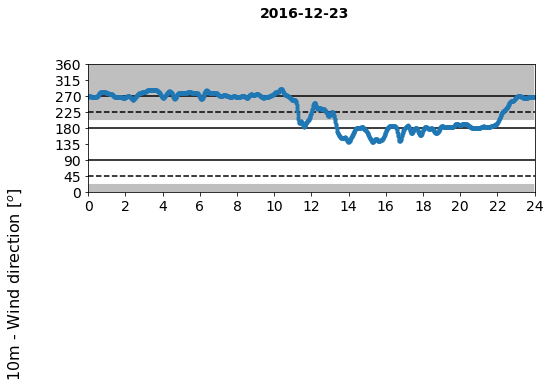

In [11]:
year = '2016'
month = '12'
day = '23'

fig = plt.figure(figsize=(8,8))

fig.text(.0, .5, '10m - Wind direction [$^{o}$]', ha='center', va='center', rotation='vertical', fontsize = 16)

ax1 = fig.add_subplot(311)
ax1.plot(obs_wind_dir_rolling[int(year+month+day)][:,:],'.')
ax1.hlines(270,0,obs_wind_dir_rolling[int(year+month+day)].shape[0])
ax1.hlines(180,0,obs_wind_dir_rolling[int(year+month+day)].shape[0])
ax1.hlines(90,0,obs_wind_dir_rolling[int(year+month+day)].shape[0])
ax1.hlines(45,0,obs_wind_dir_rolling[int(year+month+day)].shape[0], linestyles='dashed')
ax1.hlines(225,0,obs_wind_dir_rolling[int(year+month+day)].shape[0], linestyles='dashed')

ax1.fill_between(np.arange(obs_wind_dir_rolling[int(year+month+day)].shape[0]), 202.5, 360,  facecolor='gray', alpha=0.5)
ax1.fill_between(np.arange(obs_wind_dir_rolling[int(year+month+day)].shape[0]), 0, 22.5,  facecolor='gray', alpha=0.5)

ax1.set_xlim([0, obs_wind_dir_rolling[int(year+month+day)].shape[0]-1])
ax1.set_ylim([0, 360])
ax1.set_xticks(np.arange(0,obs_wind_dir_rolling[int(year+month+day)].shape[0]+120,120))    
ax1.set_xticklabels([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24 ])
ax1.set_yticks(np.arange(0,405,45))
fig.suptitle("%s-%s-%s" %(year,month,day), fontsize=14,fontweight='bold')
ax1.tick_params(labelsize=14)
plt.show()

In [12]:
diff_perc_monthly = np.zeros(shape=meps_total.shape)
diff_perc_season = np.zeros(shape=meps_sum.shape)

diff_perc_monthly_east = np.zeros(shape=meps_total_east.shape)
diff_perc_season_east = np.zeros(shape=meps_east_sum.shape)

diff_perc_monthly_west = np.zeros(shape=meps_total_west.shape)
diff_perc_season_west = np.zeros(shape=meps_west_sum.shape)
for ens_memb in range(10):
    diff_perc_monthly[:,ens_memb] = (meps_total[:,ens_memb] - np.array(obs_total))/np.array(obs_total)*100
    diff_perc_season[ens_memb]  = (meps_sum[ens_memb] - sum(obs_total_precip.values()))/sum(obs_total_precip.values())*100
    
    diff_perc_monthly_east[:,ens_memb] = (meps_total_east[:,ens_memb] - np.array(obs_total_east))/np.array(obs_total_east)*100
    diff_perc_season_east[ens_memb]  = (meps_east_sum[ens_memb] - sum(obs_precip_east.values()))/sum(obs_precip_east.values())*100
    
    diff_perc_monthly_west[:,ens_memb] = (meps_total_west[:,ens_memb] - np.array(obs_total_west))/np.array(obs_total_west)*100
    diff_perc_season_west[ens_memb]  = (meps_west_sum[ens_memb] - sum(obs_precip_west.values()))/sum(obs_precip_west.values())*100

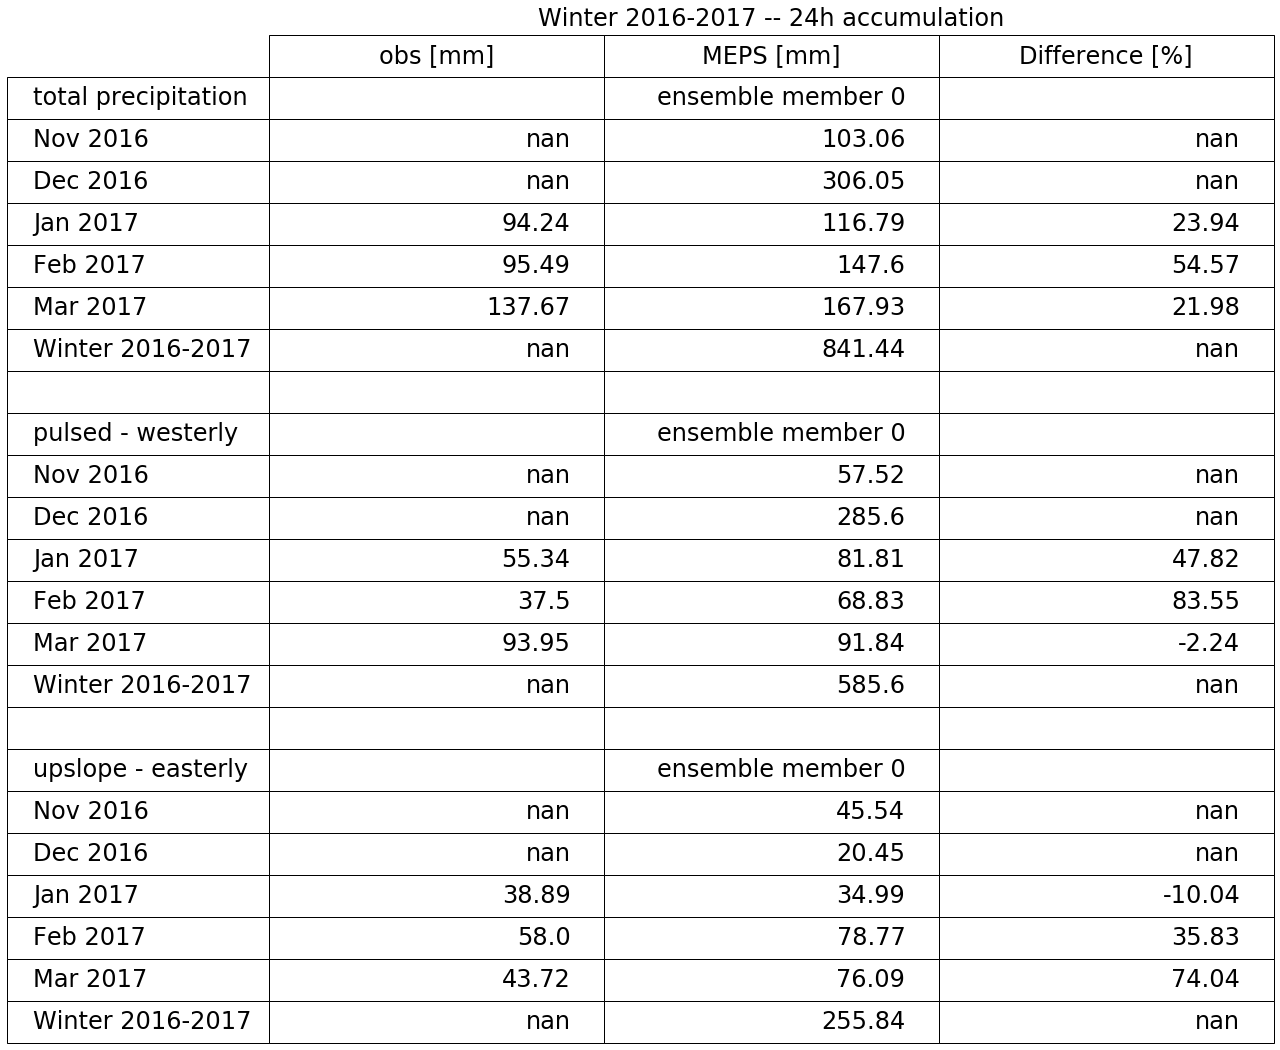

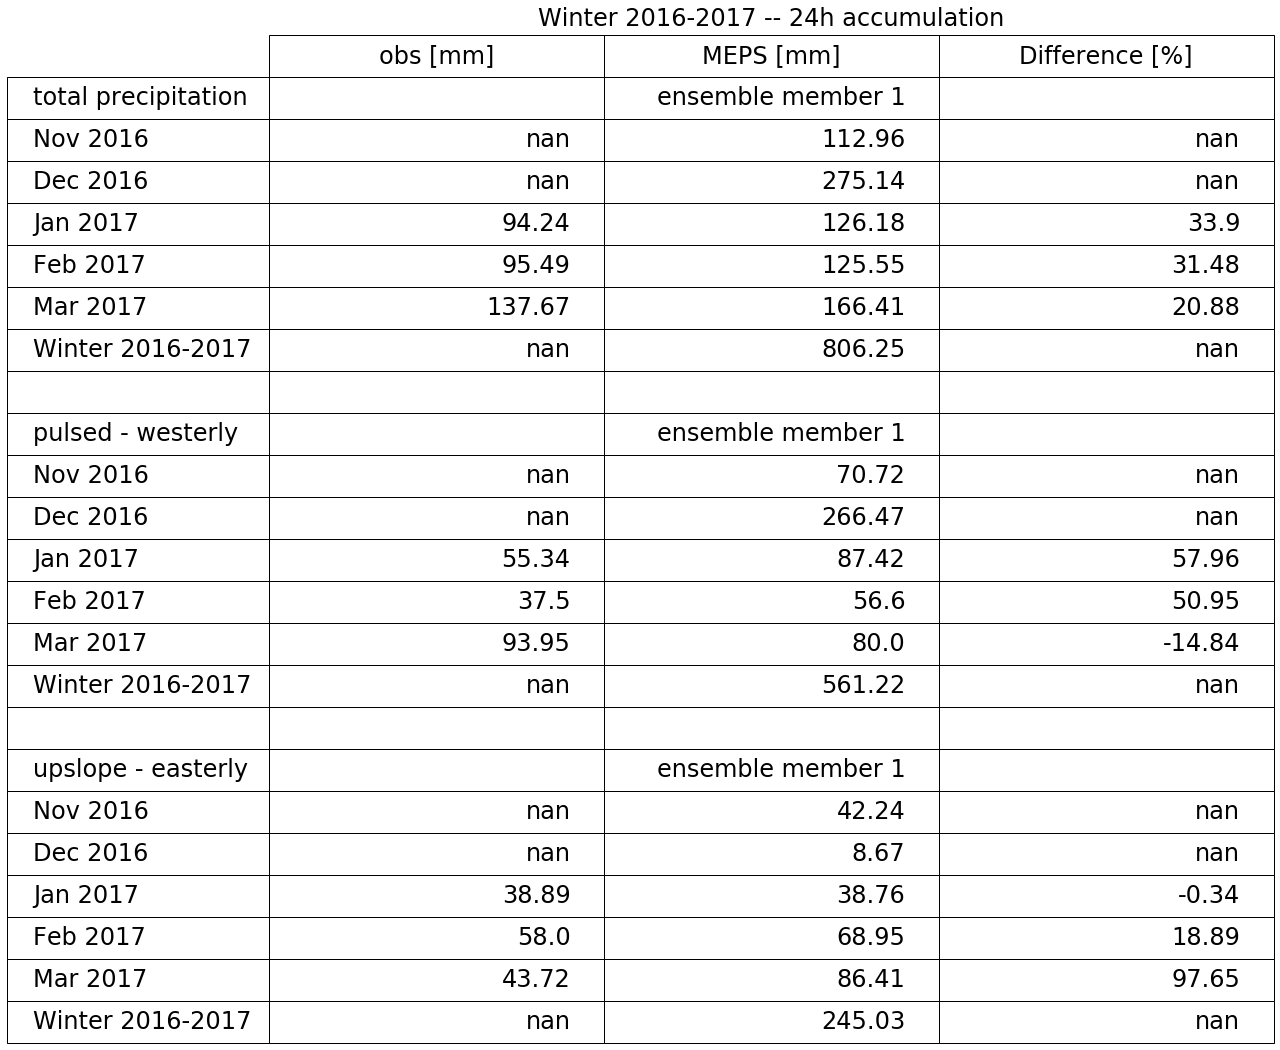

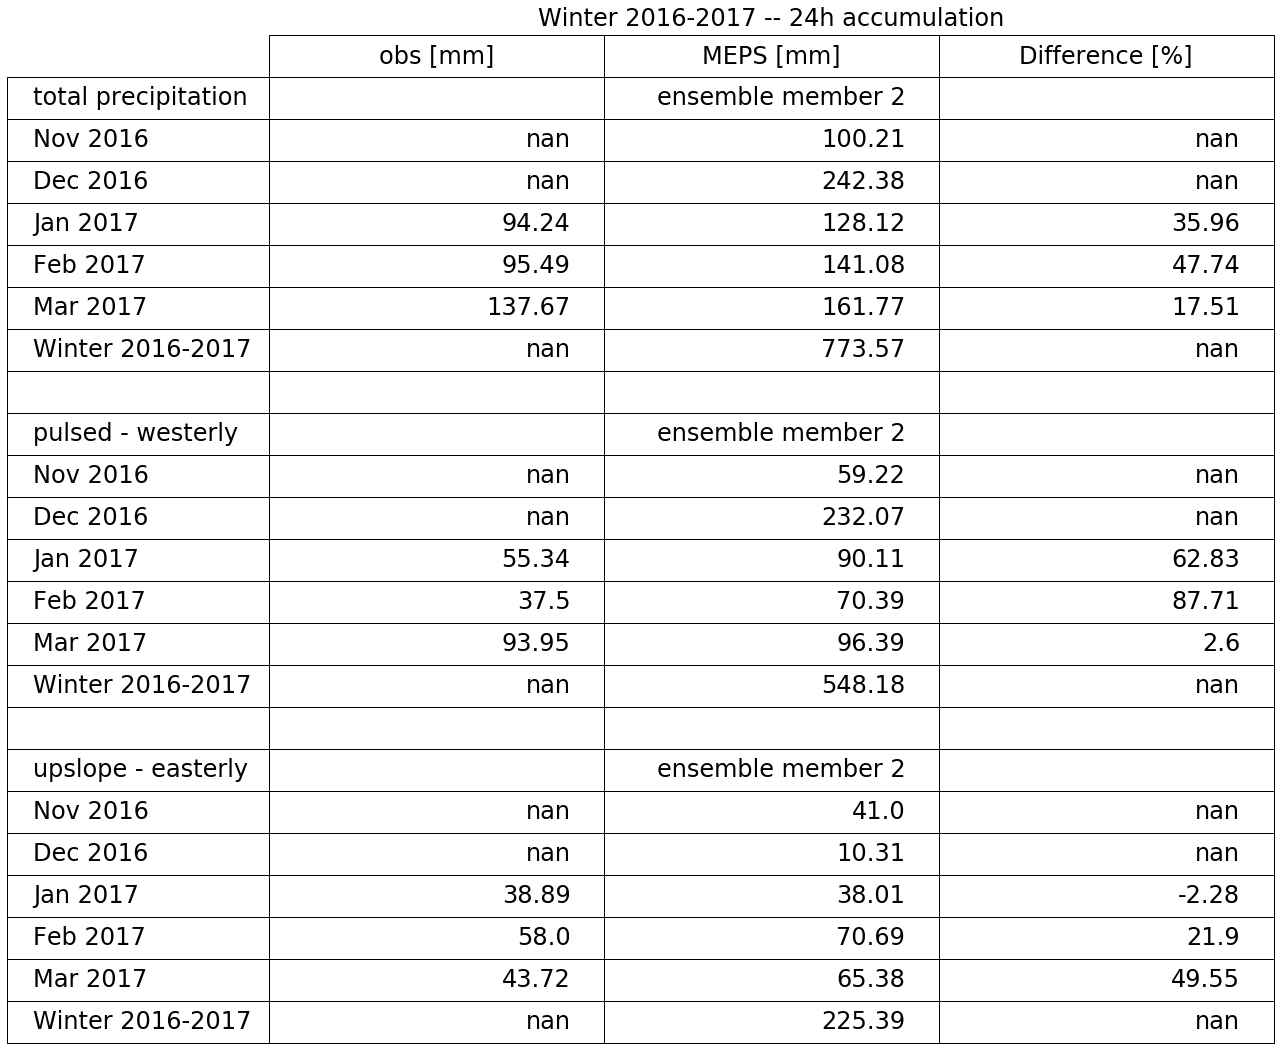

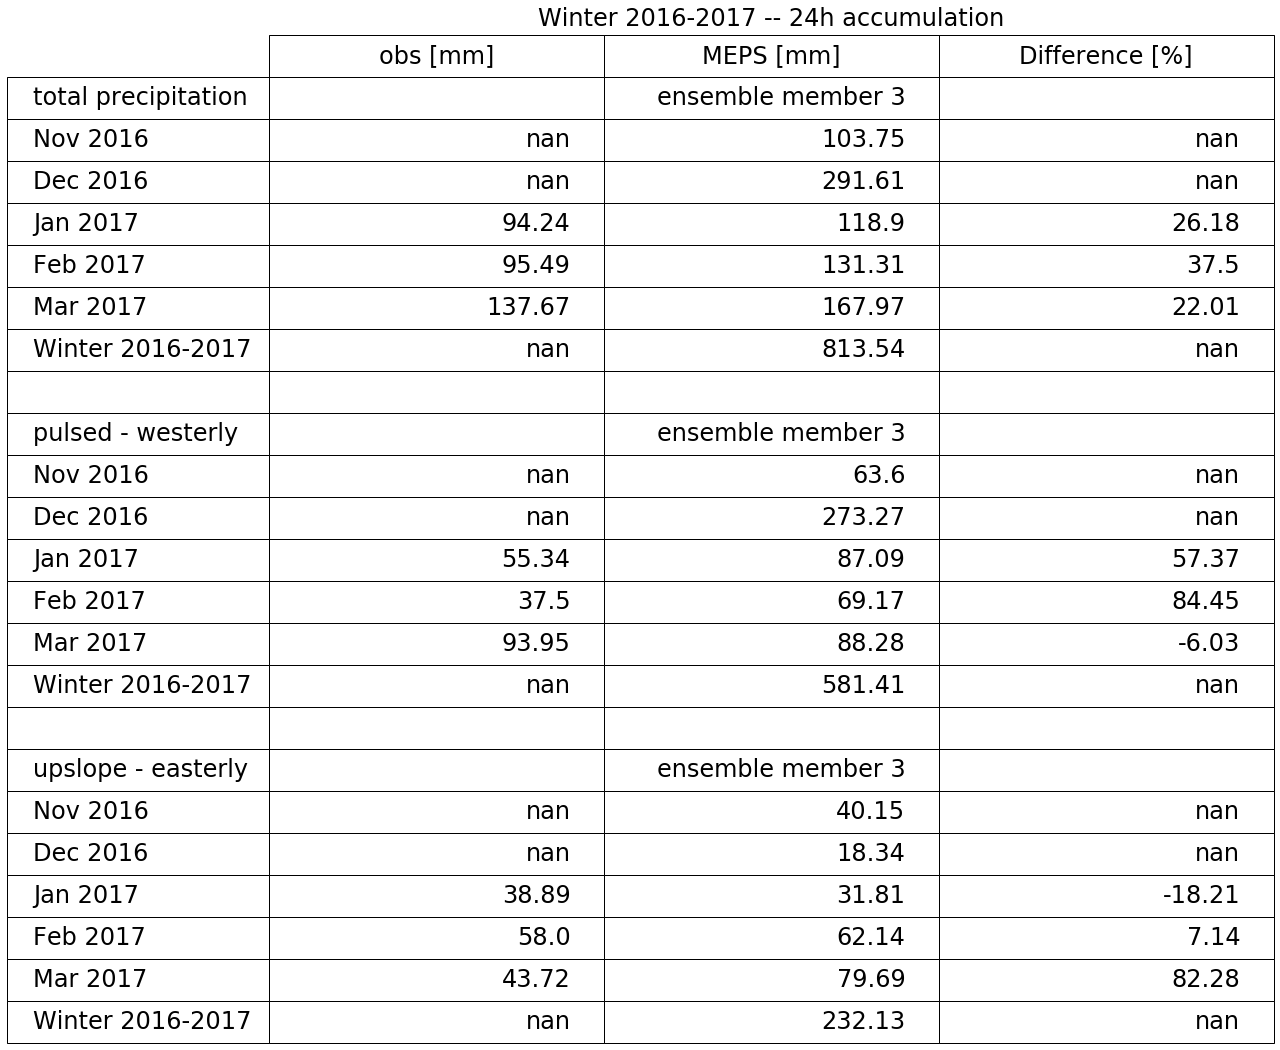

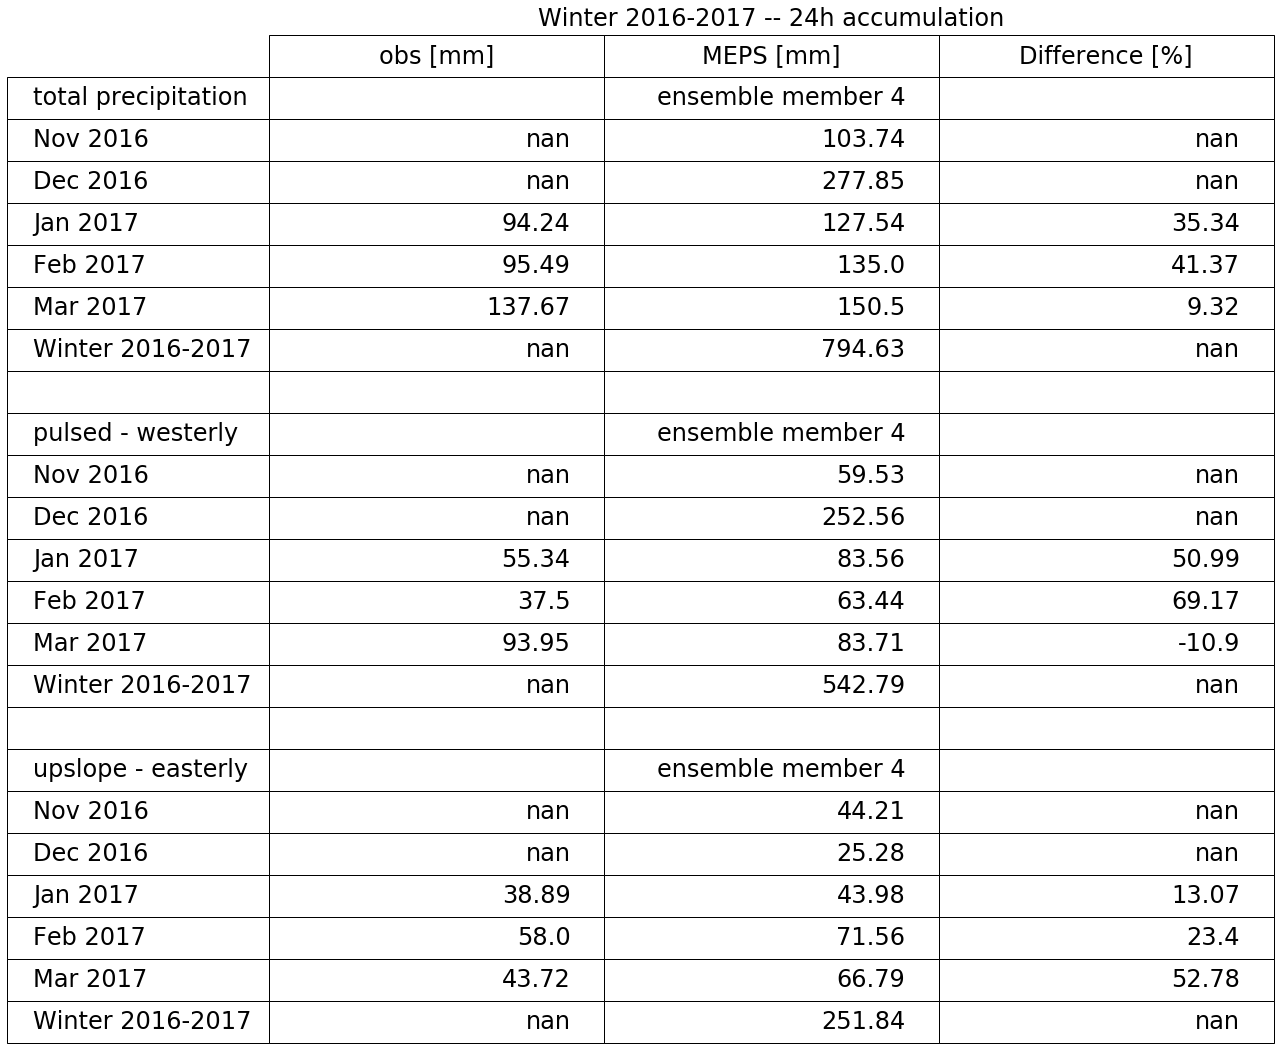

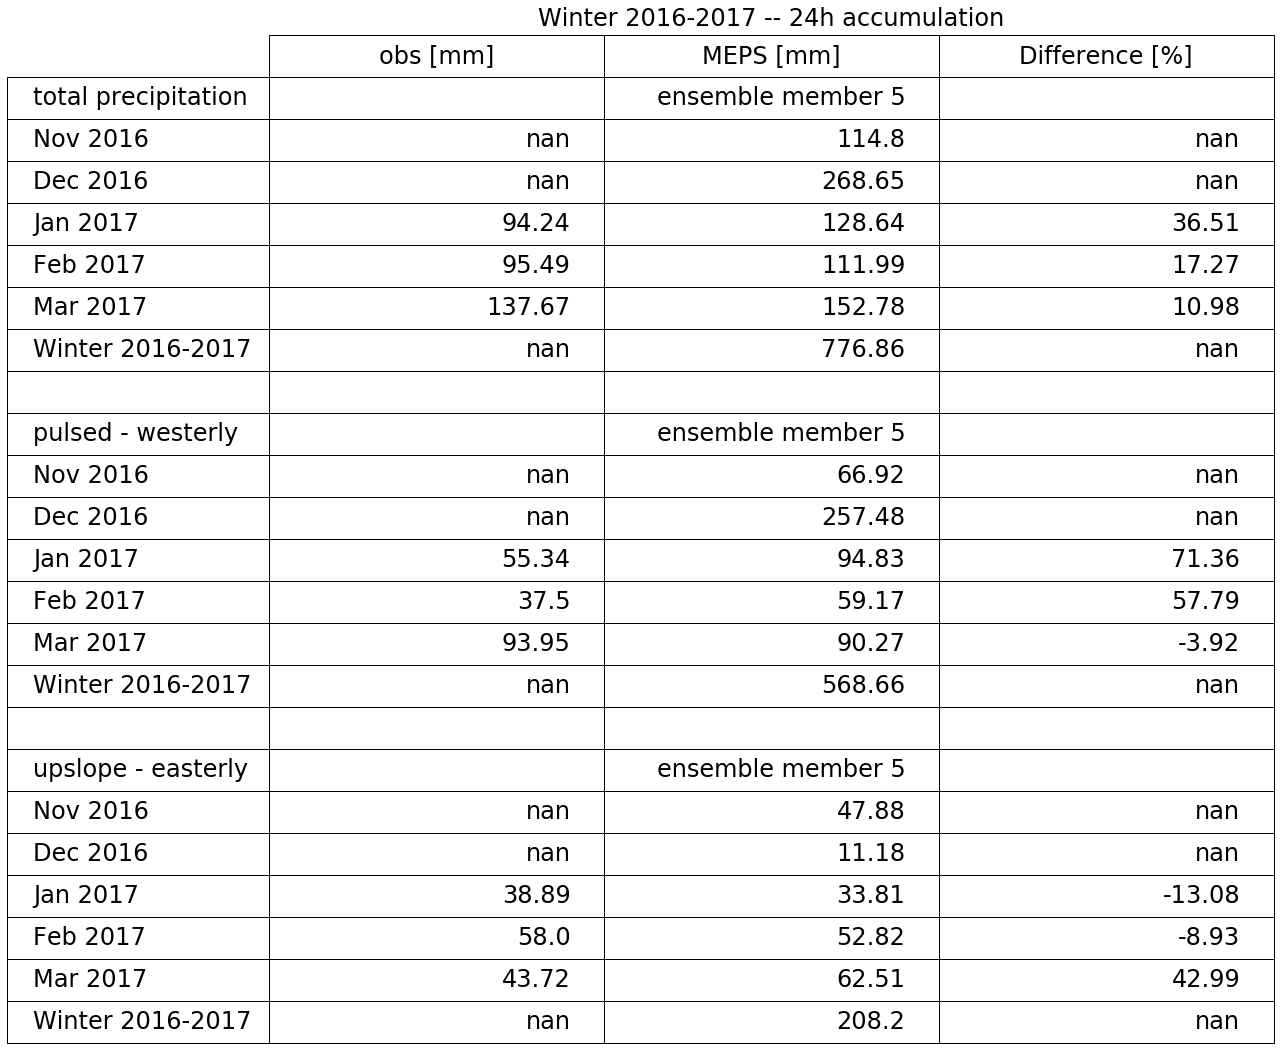

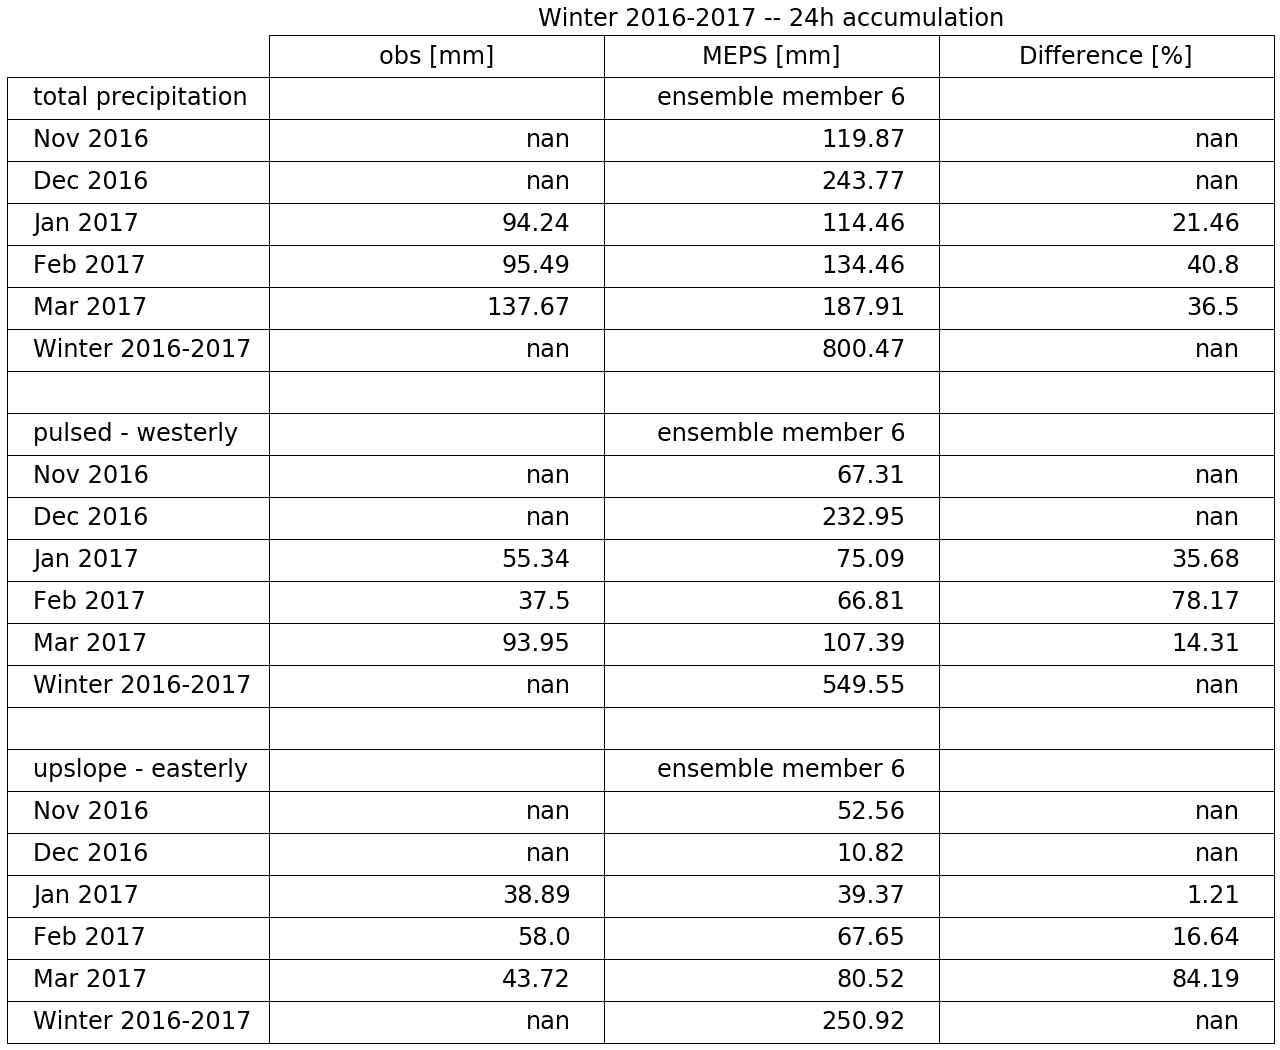

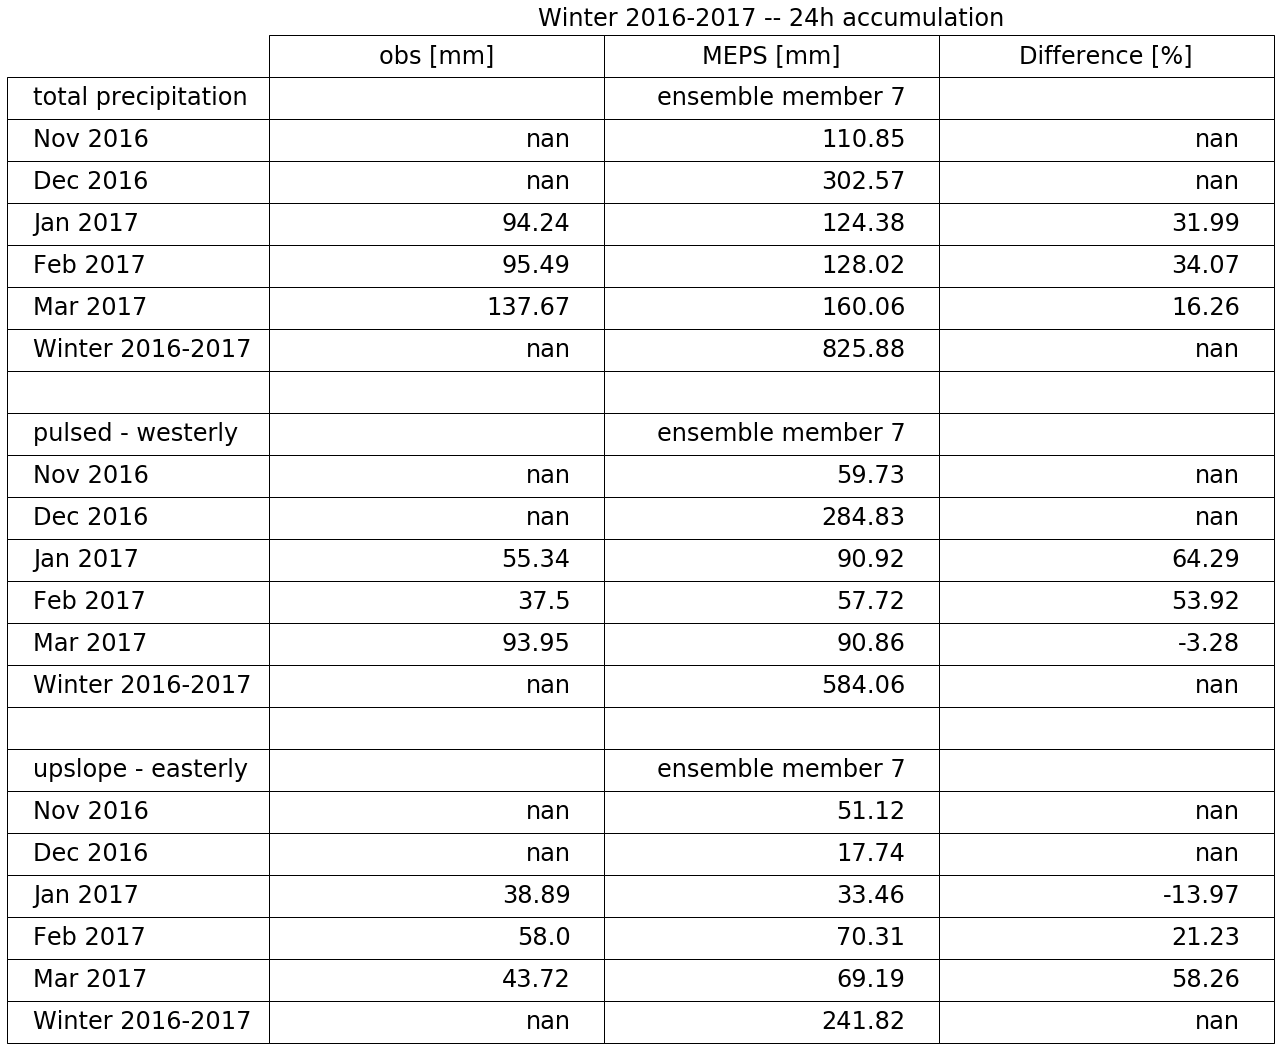

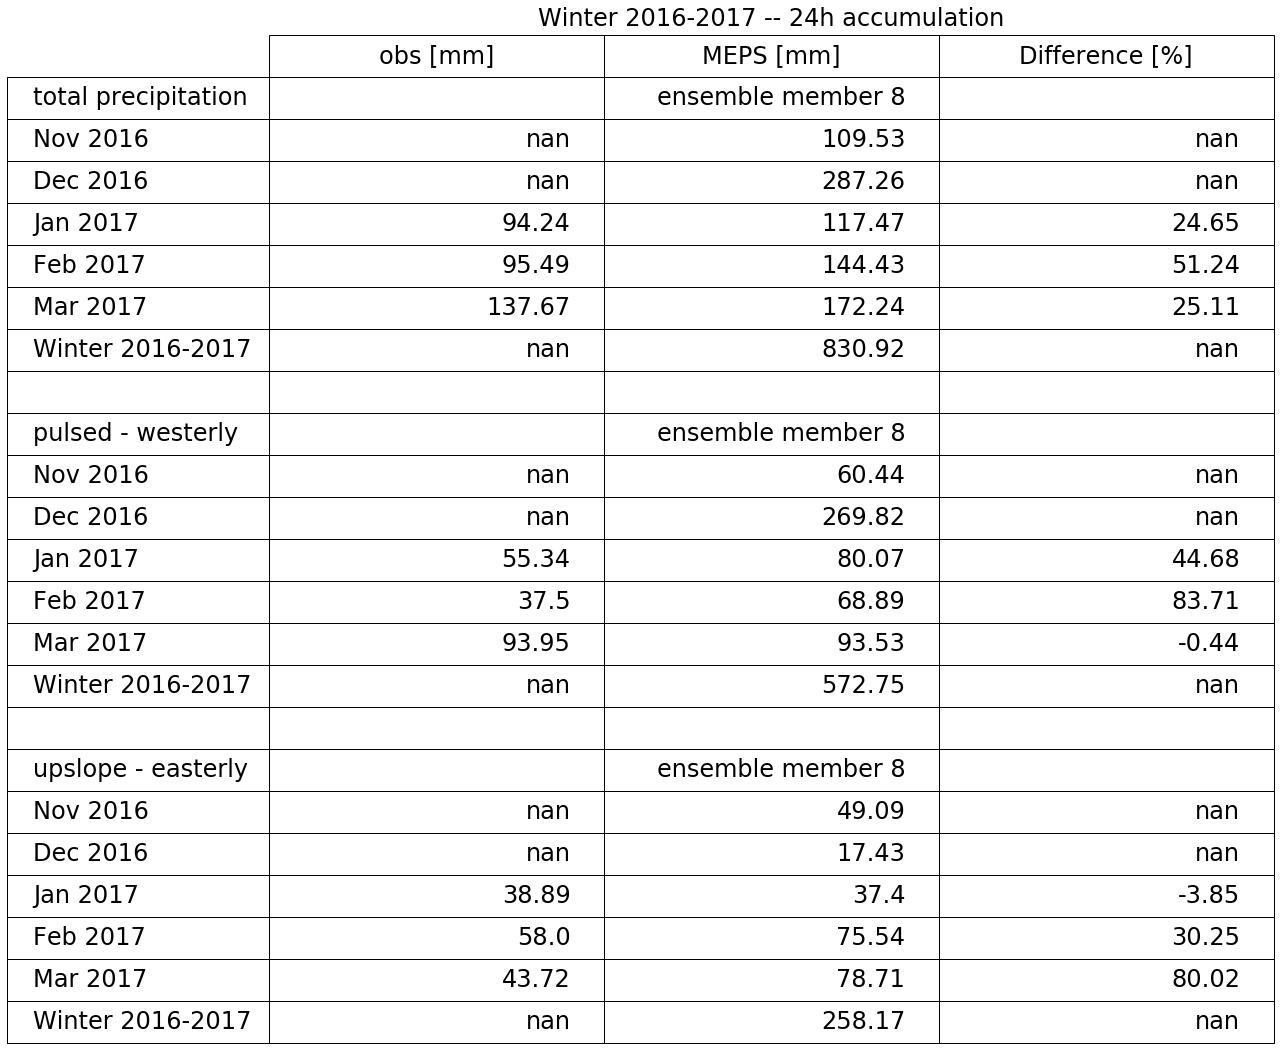

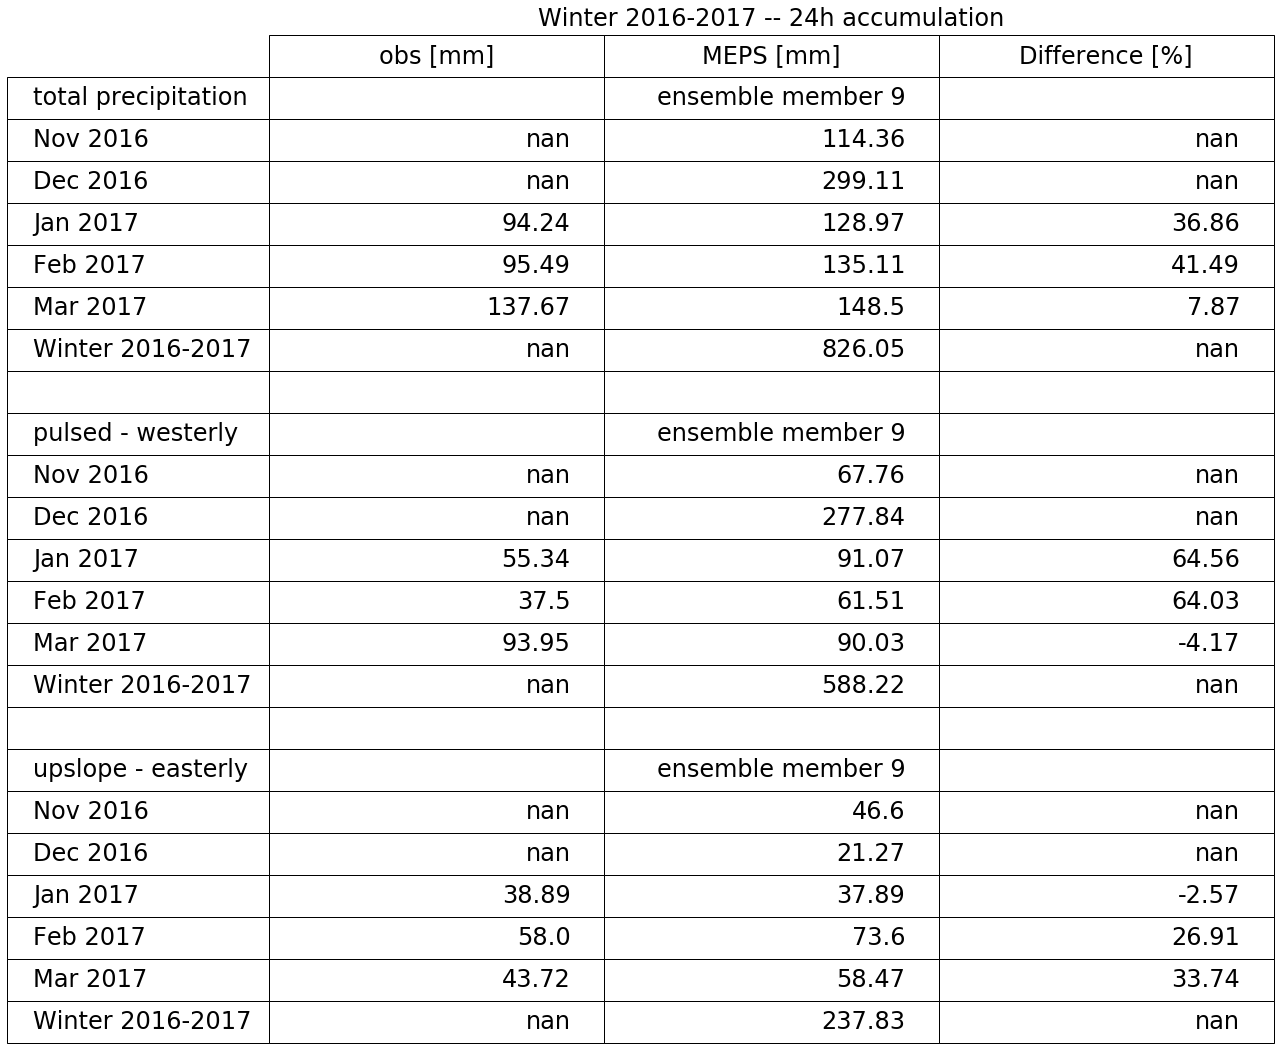

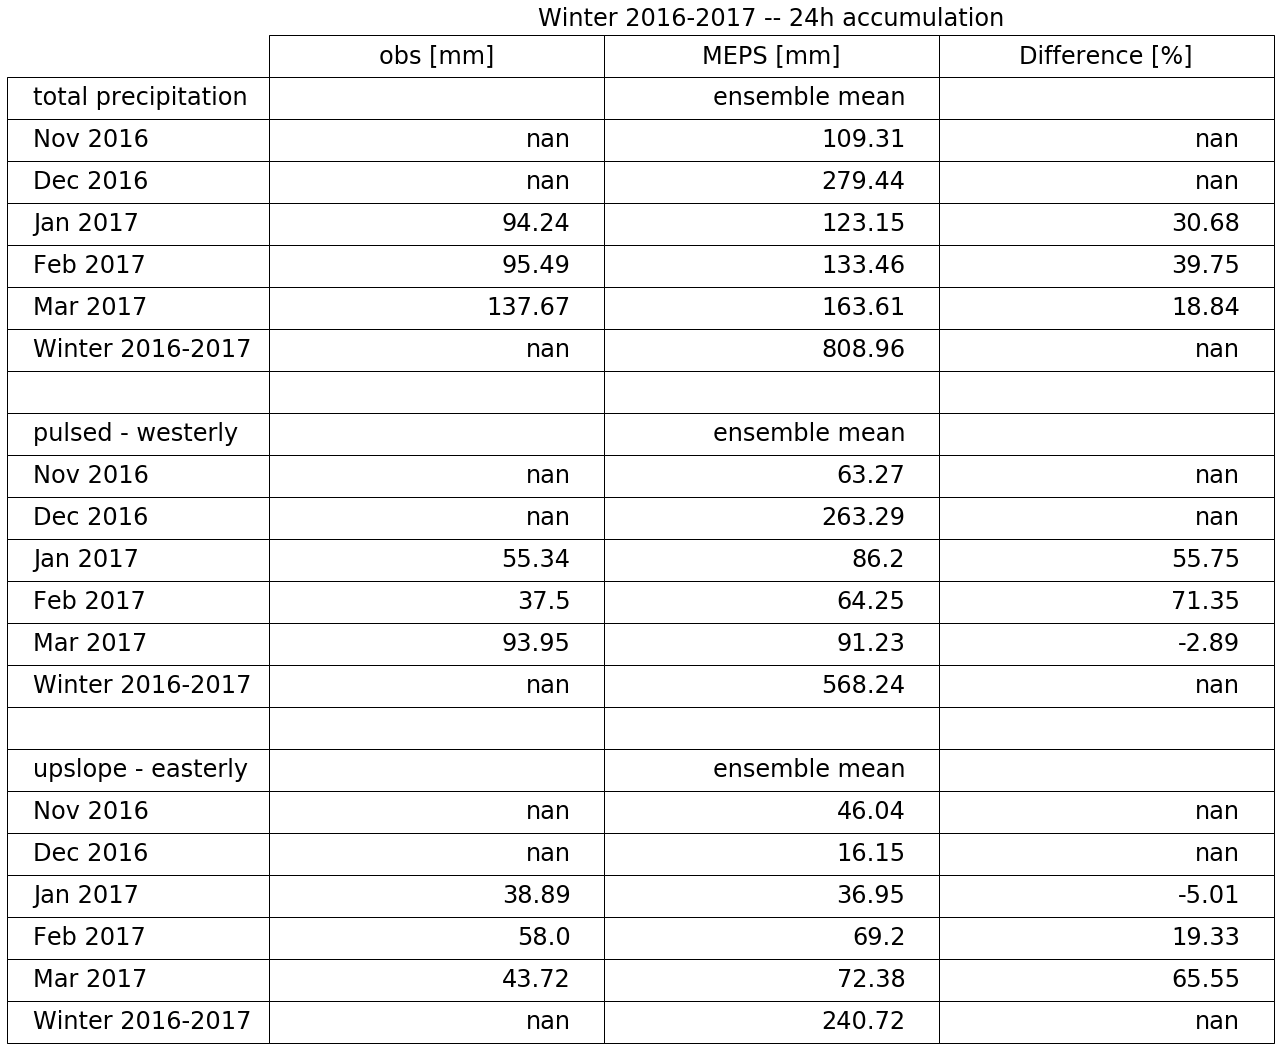

In [13]:
### create table

col_labels = ['obs [mm]', 'MEPS [mm]','Difference [%]', ]
row_labels = ['total precipitation', 'Nov 2016', 'Dec 2016', 'Jan 2017', 'Feb 2017', 'Mar 2017', 'Winter 2016-2017',
              '', 
              'pulsed - westerly', 'Nov 2016', 'Dec 2016', 'Jan 2017', 'Feb 2017', 'Mar 2017', 'Winter 2016-2017',
              '',
              'upslope - easterly', 'Nov 2016', 'Dec 2016', 'Jan 2017', 'Feb 2017', 'Mar 2017', 'Winter 2016-2017']
#for ens_memb in range(10):
for ens_memb in np.arange(10):
    table_vals = [ ['', 'ensemble member %s' %ens_memb, '' ],
               [np.round(obs_total[0],2), np.round(meps_total[0,ens_memb],2), np.round(diff_perc_monthly[0,ens_memb],2)],
               [np.round(obs_total[1],2), np.round(meps_total[1,ens_memb],2), np.round(diff_perc_monthly[1,ens_memb],2)],
               [np.round(obs_total[2],2), np.round(meps_total[2,ens_memb],2), np.round(diff_perc_monthly[2,ens_memb],2)],
               [np.round(obs_total[3],2), np.round(meps_total[3,ens_memb],2), np.round(diff_perc_monthly[3,ens_memb],2)],
               [np.round(obs_total[4],2), np.round(meps_total[4,ens_memb],2), np.round(diff_perc_monthly[4,ens_memb],2)],
               [np.round(sum(obs_total_precip.values()),2), np.round(meps_sum[ens_memb],2), np.round(diff_perc_season[ens_memb],2)],
               ['', '', ''],
               ['', 'ensemble member %s' %ens_memb, '' ],
               [np.round(obs_total_west[0],2), np.round(meps_total_west[0,ens_memb],2), np.round(diff_perc_monthly_west[0,ens_memb],2)],
               [np.round(obs_total_west[1],2), np.round(meps_total_west[1,ens_memb],2), np.round(diff_perc_monthly_west[1,ens_memb],2)],
               [np.round(obs_total_west[2],2), np.round(meps_total_west[2,ens_memb],2), np.round(diff_perc_monthly_west[2,ens_memb],2)],
               [np.round(obs_total_west[3],2), np.round(meps_total_west[3,ens_memb],2), np.round(diff_perc_monthly_west[3,ens_memb],2)],
               [np.round(obs_total_west[4],2), np.round(meps_total_west[4,ens_memb],2), np.round(diff_perc_monthly_west[4,ens_memb],2)],
               [np.round(sum(obs_precip_west.values()),2), np.round(meps_west_sum[ens_memb],2), np.round(diff_perc_season_west[ens_memb],2)],
               ['', '', ''],
               ['', 'ensemble member %s' %ens_memb, '' ],
               [np.round(obs_total_east[0],2), np.round(meps_total_east[0,ens_memb],2), np.round(diff_perc_monthly_east[0,ens_memb],2)],
               [np.round(obs_total_east[1],2), np.round(meps_total_east[1,ens_memb],2), np.round(diff_perc_monthly_east[1,ens_memb],2)],
               [np.round(obs_total_east[2],2), np.round(meps_total_east[2,ens_memb],2), np.round(diff_perc_monthly_east[2,ens_memb],2)],
               [np.round(obs_total_east[3],2), np.round(meps_total_east[3,ens_memb],2), np.round(diff_perc_monthly_east[3,ens_memb],2)],
               [np.round(obs_total_east[4],2), np.round(meps_total_east[4,ens_memb],2), np.round(diff_perc_monthly_east[4,ens_memb],2)],
               [np.round(sum(obs_precip_east.values()),2), np.round(meps_east_sum[ens_memb],2), np.round(diff_perc_season_east[ens_memb],2)]]


# Draw table
    fig = plt.figure()
    ax = fig.add_subplot(111)
    the_table = plt.table(cellText = table_vals,
                     rowLabels = row_labels,
                     colLabels = col_labels,
                     loc = 'center'
                     )
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(24)
    the_table.scale(3,3.5)

# Removing ticks and spines enables you to get the figure only with table
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    for pos in ['right','top','bottom','left']:
        plt.gca().spines[pos].set_visible(False)
    
    yy = 2.83
    fig_name = station+'_winter_16_17_EM'+str(ens_memb)+'.'+form
    ax.set_title( 'Winter 2016-2017 -- 24h accumulation', y =yy,
                 fontsize = 24)

    if savefig == 1:
        plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight')
        print('plot saved: %s/%s' %(figdir,fig_name))
    else:
        plt.show()
    plt.close()
    
    if ens_memb == 9:
        table_vals = [ ['', 'ensemble mean' , '' ],
               [np.round(obs_total[0],2), np.round(np.mean(meps_total, axis = 1)[0],2), np.round(np.mean(diff_perc_monthly, axis=1)[0],2)],
               [np.round(obs_total[1],2), np.round(np.mean(meps_total, axis = 1)[1],2), np.round(np.mean(diff_perc_monthly, axis=1)[1],2)],
               [np.round(obs_total[2],2), np.round(np.mean(meps_total, axis = 1)[2],2), np.round(np.mean(diff_perc_monthly, axis=1)[2],2)],
               [np.round(obs_total[3],2), np.round(np.mean(meps_total, axis = 1)[3],2), np.round(np.mean(diff_perc_monthly, axis=1)[3],2)],
               [np.round(obs_total[4],2), np.round(np.mean(meps_total, axis = 1)[4],2), np.round(np.mean(diff_perc_monthly, axis=1)[4],2)],
               [np.round(sum(obs_total_precip.values()),2), np.round(np.mean(meps_sum, axis = 0),2), np.round(np.mean(diff_perc_season, axis = 0),2)],
               ['', '', ''],
               ['', 'ensemble mean' , '' ],
               [np.round(obs_total_west[0],2), np.round(np.mean(meps_total_west, axis=1)[0],2), np.round(np.mean(diff_perc_monthly_west, axis=1)[0],2)],
               [np.round(obs_total_west[1],2), np.round(np.mean(meps_total_west, axis=1)[1],2), np.round(np.mean(diff_perc_monthly_west, axis=1)[1],2)],
               [np.round(obs_total_west[2],2), np.round(np.mean(meps_total_west, axis=1)[2],2), np.round(np.mean(diff_perc_monthly_west, axis=1)[2],2)],
               [np.round(obs_total_west[3],2), np.round(np.mean(meps_total_west, axis=1)[3],2), np.round(np.mean(diff_perc_monthly_west, axis=1)[3],2)],
               [np.round(obs_total_west[4],2), np.round(np.mean(meps_total_west, axis=1)[4],2), np.round(np.mean(diff_perc_monthly_west, axis=1)[4],2)],
               [np.round(sum(obs_precip_west.values()),2), np.round(np.mean(meps_west_sum, axis = 0),2), np.round(np.mean(diff_perc_season_west, axis = 0),2)],
               ['', '', ''],
               ['', 'ensemble mean' , '' ],
               [np.round(obs_total_east[0],2), np.round(np.mean(meps_total_east, axis=1)[0],2), np.round(np.mean(diff_perc_monthly_east, axis=1)[0],2)],
               [np.round(obs_total_east[1],2), np.round(np.mean(meps_total_east, axis=1)[1],2), np.round(np.mean(diff_perc_monthly_east, axis=1)[1],2)],
               [np.round(obs_total_east[2],2), np.round(np.mean(meps_total_east, axis=1)[2],2), np.round(np.mean(diff_perc_monthly_east, axis=1)[2],2)],
               [np.round(obs_total_east[3],2), np.round(np.mean(meps_total_east, axis=1)[3],2), np.round(np.mean(diff_perc_monthly_east, axis=1)[3],2)],
               [np.round(obs_total_east[4],2), np.round(np.mean(meps_total_east, axis=1)[4],2), np.round(np.mean(diff_perc_monthly_east, axis=1)[4],2)],
               [np.round(sum(obs_precip_east.values()),2), np.round(np.mean(meps_east_sum, axis = 0),2), np.round(np.mean(diff_perc_season_east, axis = 0),2)]]
        # Draw table
        fig = plt.figure()
        ax = fig.add_subplot(111)
        the_table = plt.table(cellText = table_vals,
                     rowLabels = row_labels,
                     colLabels = col_labels,
                     loc = 'center'
                     )
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(24)
        the_table.scale(3,3.5)

# Removing ticks and spines enables you to get the figure only with table
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
        for pos in ['right','top','bottom','left']:
            plt.gca().spines[pos].set_visible(False)
        yy = 2.83
        fig_name = station+'_winter_16_17_ensemble_mean'+'.'+form
        ax.set_title( 'Winter 2016-2017 -- 24h accumulation', y =yy,
                 fontsize = 24)

        if savefig == 1:
            plt.savefig('%s/%s' % (figdir, fig_name), format = form, bbox_inches='tight')
            print('plot saved: %s/%s' %(figdir,fig_name))
        else:
            plt.show()
        plt.close()

### Retrieval data

In [14]:
ret_f = dict()
ret_accumulation = dict()
ret_total_precip = dict()
ret_precip_east = dict()
ret_precip_west = dict()


for month in m:
    if month == '11':
        t = np.arange(8,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day
        
        ret_dirnc = '../../Data/Retrieval/%s/combined/precip_wind_temp_%s%s%s.nc' %(station,year,month,day)
        ret_f[int(year+month+day)] = netCDF4.Dataset(ret_dirnc, 'r')

        ret_accumulation[int(year+month+day)] = (ret_f[int(year+month+day)].variables['precip_amount'][:])

        # assign sum values to days
        ret_total_precip[int(year+month+day)] = ret_f[int(year+month+day)].variables['24h_precip_sum'][:]
        ret_precip_east[int(year+month+day)] = ret_f[int(year+month+day)].variables['24h_upslope_sum'][:]
        ret_precip_west[int(year+month+day)] = ret_f[int(year+month+day)].variables['24h_pulsed_sum'][:]
        
        
        
        ## set days, still with not exisiting observation data to 0 mm precipitation
        if np.isnan(obs_total_precip[int(year+month+day)]):
            print([int(year+month+day)], 'total precip is NAN')
            obs_total_precip[int(year+month+day)] = 0.0
            meps_total_precip[int(year+month+day)] = np.zeros(shape=(10,))
            ret_total_precip[int(year+month+day)] = 0.0
        if np.isnan(obs_precip_east[int(year+month+day)]):
            print([int(year+month+day)], 'easterly is NAN')
            obs_precip_east[int(year+month+day)] = 0.0
            meps_precip_east[int(year+month+day)] = np.zeros(shape=(10,))
            ret_precip_east[int(year+month+day)] = 0.0
        if np.isnan(obs_precip_west[int(year+month+day)]):
            print([int(year+month+day)], 'westerly is NAN')
            obs_precip_west[int(year+month+day)] = 0.0
            meps_precip_west[int(year+month+day)] = np.zeros(shape=(10,))
            ret_precip_west[int(year+month+day)] = 0.0
        
        
        ## set days with less than 24h recorded values to 0mm precipitation 
        if np.count_nonzero(~np.isnan(obs_wind_dir_rolling[int(year+month+day)][:])) != 1440 and \
           np.count_nonzero(~np.isnan(obs_wind_dir_rolling[int(year+month+day)][:])) != 24:
            print([int(year+month+day)], 'less than 24h observation')
            obs_total_precip[int(year+month+day)] = 0.0
            meps_total_precip[int(year+month+day)] = np.zeros(shape=(10,))
            ret_total_precip[int(year+month+day)] = 0.0
            
            obs_precip_east[int(year+month+day)] = 0.0
            meps_precip_east[int(year+month+day)] = np.zeros(shape=(10,))
            ret_precip_east[int(year+month+day)] = 0.0
            
            obs_precip_west[int(year+month+day)] = 0.0
            meps_precip_west[int(year+month+day)] = np.zeros(shape=(10,))
            ret_precip_west[int(year+month+day)] = 0.0

[20161108] total precip is NAN
[20161108] easterly is NAN
[20161108] westerly is NAN
[20161108] less than 24h observation
[20161111] total precip is NAN
[20161111] easterly is NAN
[20161111] westerly is NAN
[20161111] less than 24h observation
[20161118] less than 24h observation
[20161119] total precip is NAN
[20161119] easterly is NAN
[20161119] westerly is NAN
[20161119] less than 24h observation
[20161120] total precip is NAN
[20161120] easterly is NAN
[20161120] westerly is NAN
[20161120] less than 24h observation
[20161121] total precip is NAN
[20161121] easterly is NAN
[20161121] westerly is NAN
[20161121] less than 24h observation
[20161122] total precip is NAN
[20161122] easterly is NAN
[20161122] westerly is NAN
[20161122] less than 24h observation
[20161125] total precip is NAN
[20161125] easterly is NAN
[20161125] westerly is NAN
[20161125] less than 24h observation
[20161128] less than 24h observation
[20161201] less than 24h observation
[20161202] less than 24h observatio

In [15]:
print('total', sum(ret_total_precip.values()) ,
      'east', sum(ret_precip_east.values()),
      'west', sum(ret_precip_west.values()) )

total [406.09364836] east [146.58793312] west [259.50571524]


In [17]:
# calculate monthly precip sum
ret_total = []
ret_total_east = []
ret_total_west = []
for month in m:
    if month == '11':
        t = np.arange(8,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    ret_monthly_sum = 0.0
    ret_monthly_east_sum = 0.0
    ret_monthly_west_sum = 0.0
    
    

    for day in t:
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day
        tot_val = (ret_total_precip[int(year+month+day)])
        ret_monthly_sum = np.sum([ret_monthly_sum,tot_val])
        
        east_val = (ret_precip_east[int(year+month+day)])
        ret_monthly_east_sum = np.sum([ret_monthly_east_sum, east_val])
        
        west_val = (ret_precip_west[int(year+month+day)])
        ret_monthly_west_sum = np.sum([ret_monthly_west_sum, west_val])
        
        if int(day) == t[-1]:
            ret_total.append(ret_monthly_sum)
            ret_total_east.append(ret_monthly_east_sum)
            ret_total_west.append(ret_monthly_west_sum)
            
    print(int(year+month+day), 'total:', np.round(ret_monthly_sum,2),
                               'east:',  np.round(ret_monthly_east_sum,2),
                               'west:',  np.round(ret_monthly_west_sum,2))
print('total:', np.round(sum(ret_total_precip.values()),2), 
      'east:', np.round(sum(ret_precip_east.values()),2), 
      'west:', np.round(sum(ret_precip_west.values()),2))

20161130 total: 42.9 east: 20.49 west: 22.41
20161231 total: 150.1 east: 22.94 west: 127.16
20170131 total: 89.94 east: 49.15 west: 40.79
20170228 total: 20.84 east: 20.74 west: 0.1
20170331 total: 102.32 east: 33.26 west: 69.06
total: [406.09] east: [146.59] west: [259.51]
